[View in Colaboratory](https://colab.research.google.com/github/avyukd/glaucoma_screener/blob/master/AEH_Screening_Project.ipynb)

Keras doesn't work??? Figure out why

In [263]:
!nvidia-smi
#!pip list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip install -U
#!pip install keras_contrib 
!pip install graphviz
!apt-get install graphviz 

/bin/sh: 1: nvidia-smi: not found
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0
  libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0 libxcb-shm0
  libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgraphite2-3 libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 28 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,122 kB of

# SETUP

In [0]:
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.misc
import random
import cv2
import graphviz 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import csv
from PIL import Image
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from scipy import ndimage
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
from sklearn.datasets import make_classification
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
from google.colab import auth
auth.authenticate_user()

In [7]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [9]:
!ls drive
#!unzip drive/FundusImagesv2.zip
#!unzip drive/FundusImagesv3.zip
#!unzip -o drive/FundusImagesv4.zip
!unzip -o drive/PUBLIC_FUNDUS.zip

0dbce84c_600640.jpg
2017ShakespearePerformanceFestival-BlueDay.doc
2017ShakespearePerformanceFestival-BlueDay.doc.odt
2k17 MyPlayer Ratings Sheet v1.xlsx.ods
4ef8d50b_467995.jpg
AD_JV_WACFL4.docx
AD_JV_WACFL4.docx.odt
AEH_SCREENING_DATA.csv
AEH Screening Project.ipynb
akul_assignment.jpg
APA Table.pdf
avyukexercises.py
BPMN (19d063fc).html
BPMN.html
Canterbury Tales Essay.odt
captain vote count.ods
Captain vote count.ods
Civic Rep Aff.docx
Classroom
Colab Notebooks
Comp Sci Placement Test
ContextBuilder_Versions
CubeSat.pdf
Disease Detectives
downloadAttachments.zip
drishtiGS_027.png
DSC01280.JPG
EES Context Builder Problems Log.ods
eshaan_assignment.jpg
Event Spreadsheet TEAM BLUE_v3.xls
Event Spreadsheet TEAM BLUE_v3.xls.ods
Event Spreadsheet TEAM BLUE_v3.xls.ods (560f3c37)
Event Spreadsheet TEAM BLUE_v3.xls.ods (85de701c)
Event Spreadsheet TEAM GREEN_v3..xls
Event Spreadsheet TEAM GREEN_v3..xls.ods
FinalRobotCodeToPrint_ino.ino
First Lego League
FLL_Design_Quiz.odt
FoodGroupsAndCalo

In [0]:
!ls drive

In [0]:
import os
subdirs = os.listdir("FundusImagesv4")
print(len(os.listdir("FundusImagesv4/normal")))

98


# Deep Learning Models

In [0]:
width = 96
height = 96

In [0]:
def create_model():
    model = Sequential()
    model.add(Flatten(input_shape=(width,height,3)))
    #model = Sequential()
    #model.add(Conv2D(10, (8, 8), input_shape=(width, height, 3), kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(32, (5, 5), kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('sigmoid'))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(16))
    model.add(Activation('sigmoid'))
    model.add(Dense(8))
    model.add(Activation('sigmoid'))
    model.add(Dense(4))
    model.add(Activation('sigmoid'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    opt = optimizers.SGD(lr=.001, momentum=0.5,nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [0]:
model = create_model()
train_generator = ImageDataGenerator().flow_from_directory(
        'PUBLIC_FUNDUS/',
        target_size=(width, height),
        color_mode='rgb',
        classes=['glaucoma','normal'],
        batch_size=50)
model.fit_generator(
        train_generator,
        epochs=50)

model.save_weights("public_fund.h5")

Found 260 images belonging to 2 classes.
Epoch 1/50
6/6 [==============================] - 1s 203ms/step - loss: 0.7730 - acc: 0.4866
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 0.7963 - acc: 0.4523
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.8100 - acc: 0.4295
Epoch 4/50
6/6 [==============================] - 0s 34ms/step - loss: 0.7985 - acc: 0.4409
Epoch 5/50
6/6 [==============================] - 0s 37ms/step - loss: 0.7953 - acc: 0.4409
Epoch 6/50
6/6 [==============================] - 0s 34ms/step - loss: 0.7766 - acc: 0.4637
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 0.8051 - acc: 0.4180
Epoch 8/50
6/6 [==============================] - 0s 36ms/step - loss: 0.7941 - acc: 0.4295
Epoch 9/50
6/6 [==============================] - 0s 32ms/step - loss: 0.7835 - acc: 0.4409
Epoch 10/50
6/6 [==============================] - 0s 33ms/step - loss: 0.7736 - acc: 0.4523
Epoch 11/50
6/6 [====================

In [0]:
model.predict(test)

array([[0.41929004, 0.58070993]], dtype=float32)

# Histogram Analysis

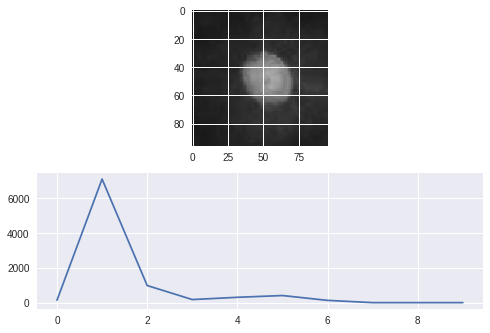

(10, 1)


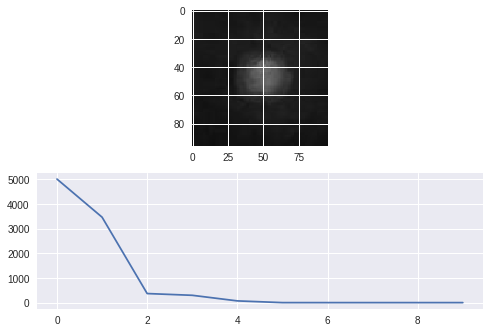

(10, 1)


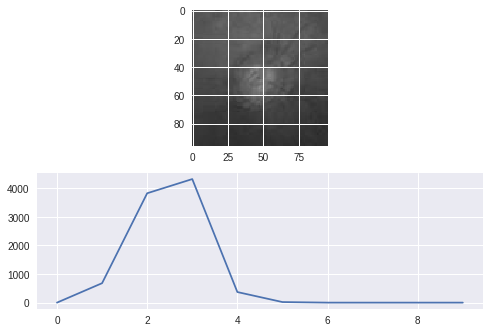

(10, 1)


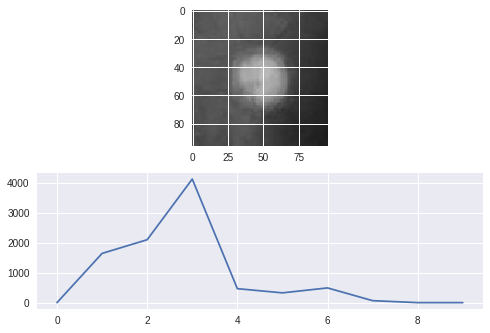

(10, 1)


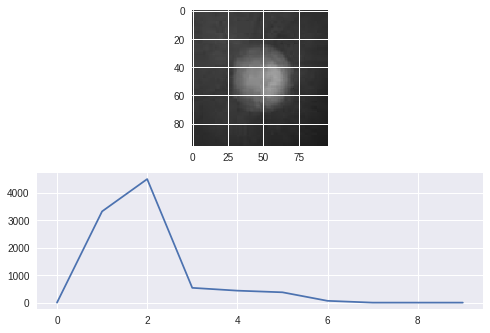

(10, 1)


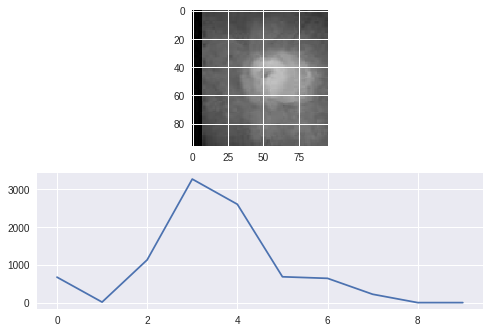

(10, 1)


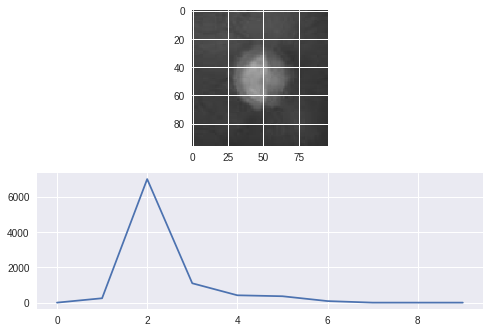

(10, 1)


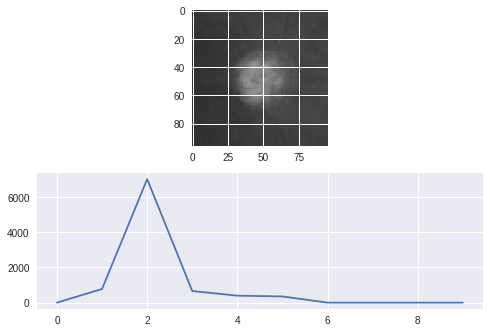

(10, 1)


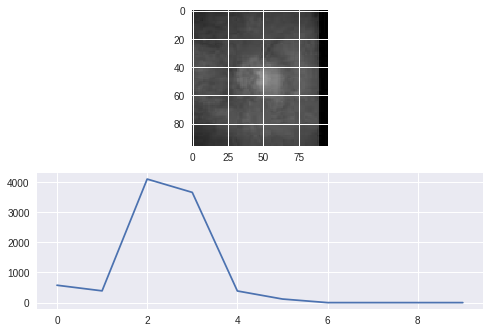

(10, 1)


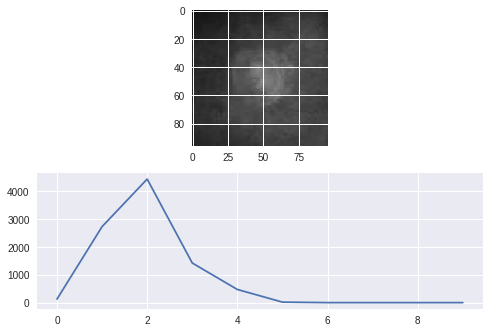

(10, 1)


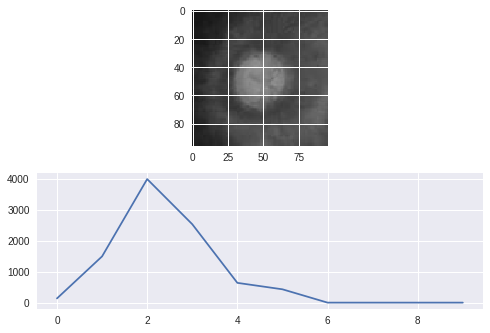

(10, 1)


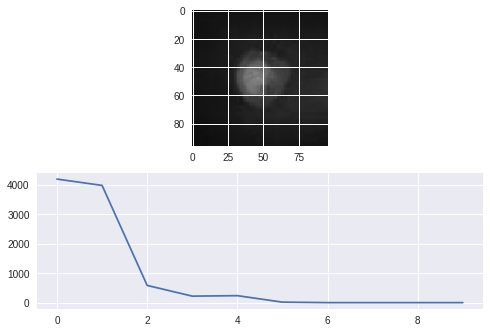

(10, 1)


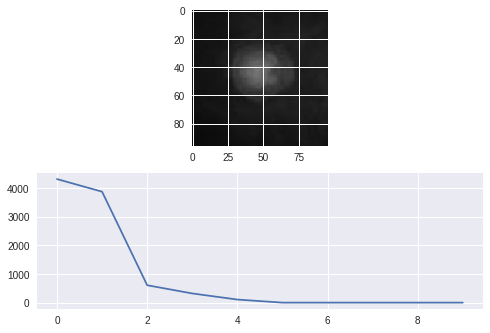

(10, 1)


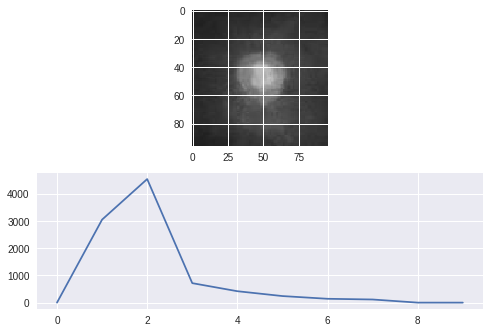

(10, 1)


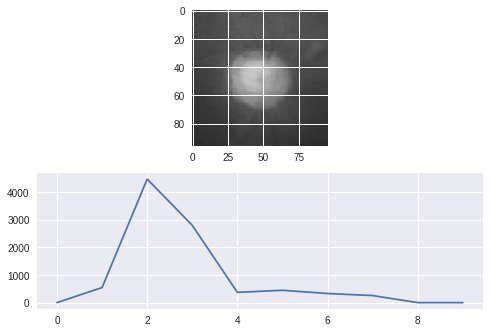

(10, 1)


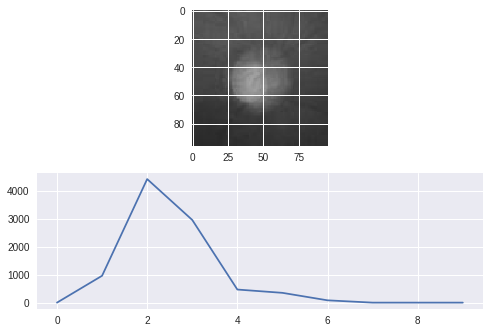

(10, 1)


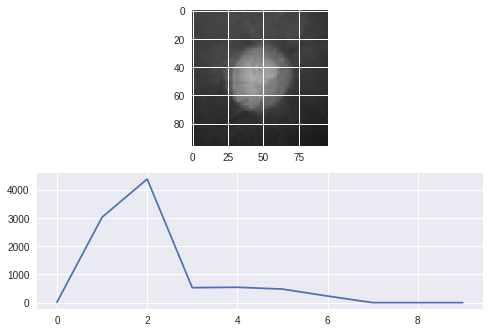

(10, 1)


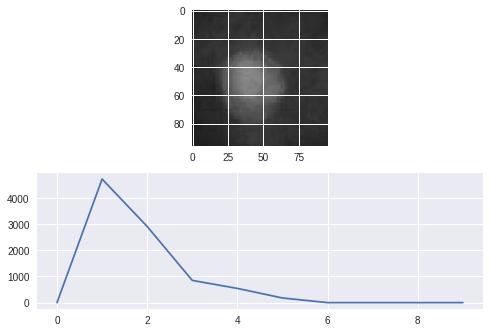

(10, 1)


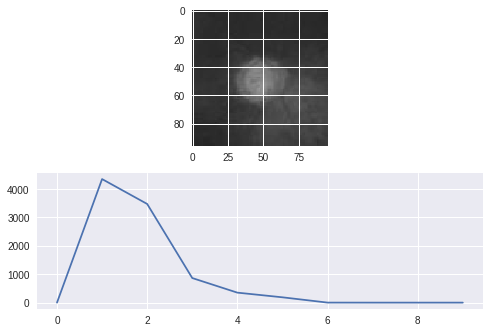

(10, 1)


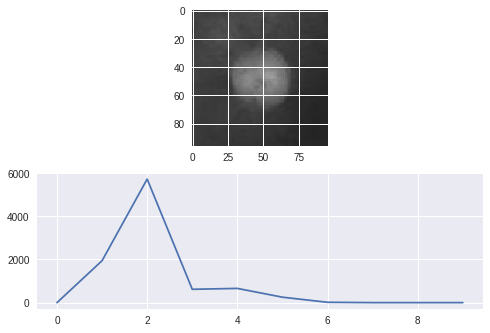

(10, 1)


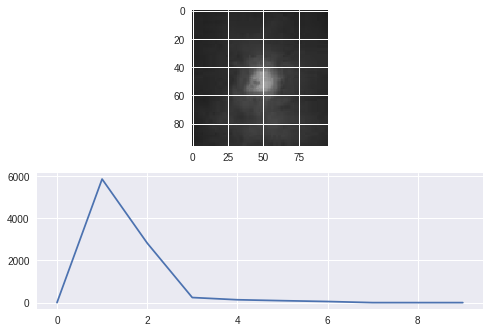

(10, 1)


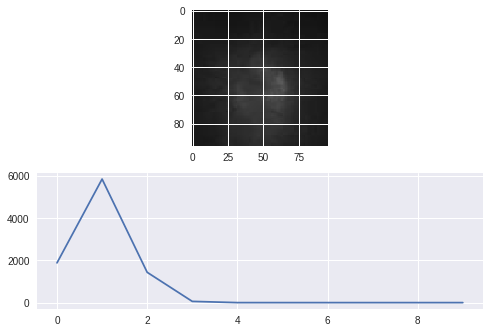

(10, 1)


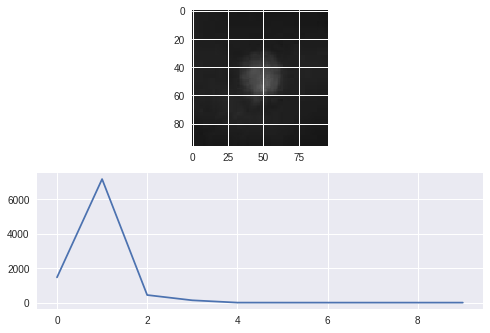

(10, 1)


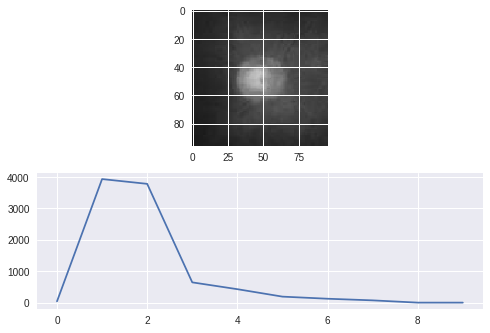

(10, 1)


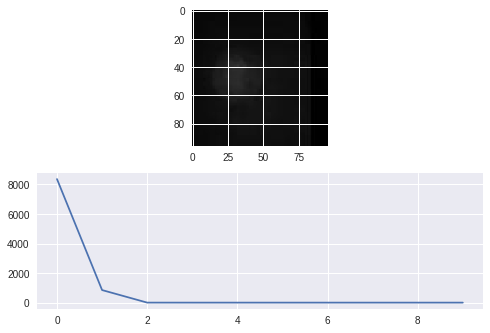

(10, 1)


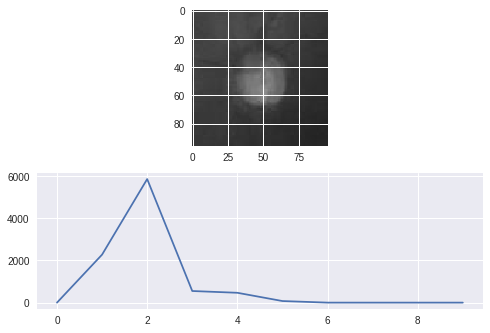

(10, 1)


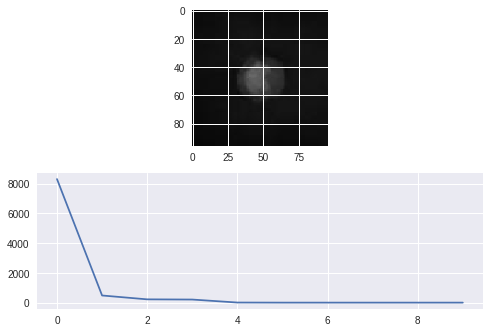

(10, 1)


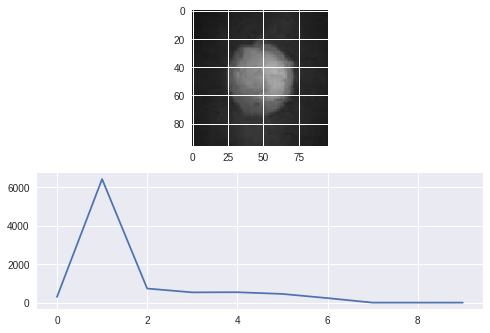

(10, 1)


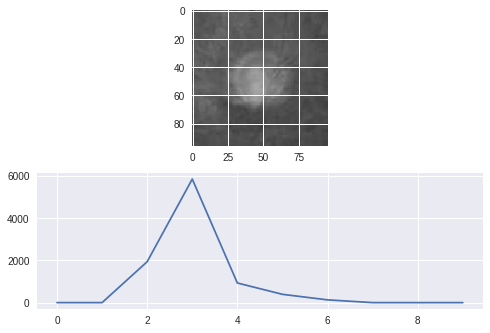

(10, 1)


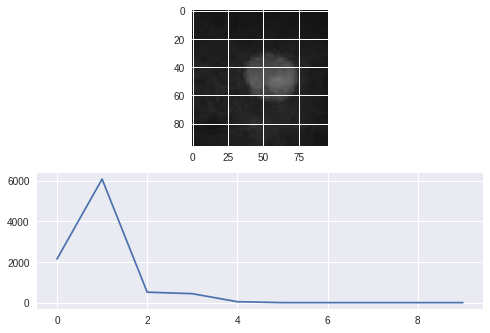

(10, 1)


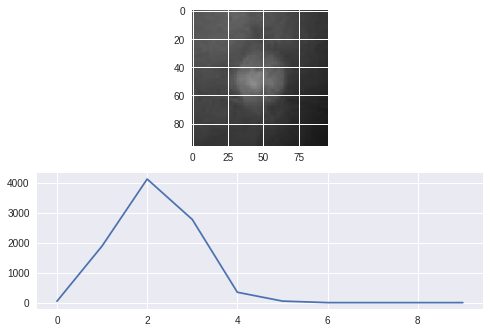

(10, 1)


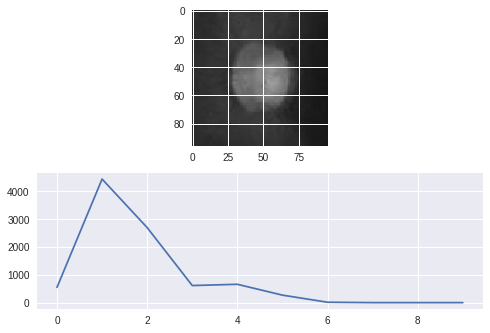

(10, 1)


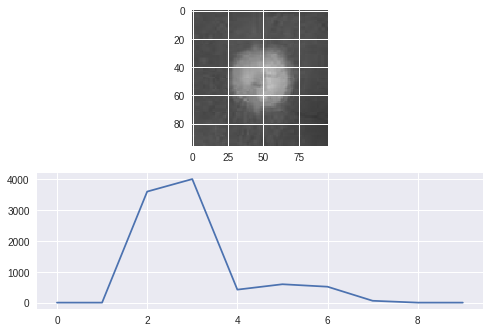

(10, 1)


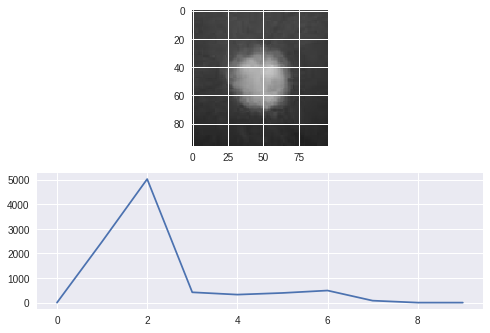

(10, 1)


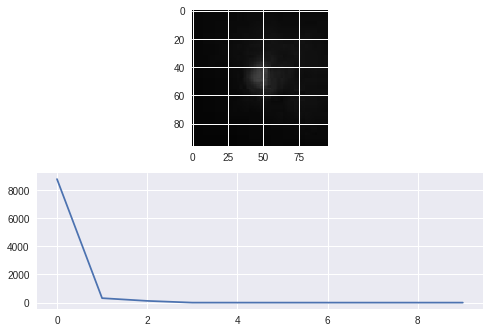

(10, 1)


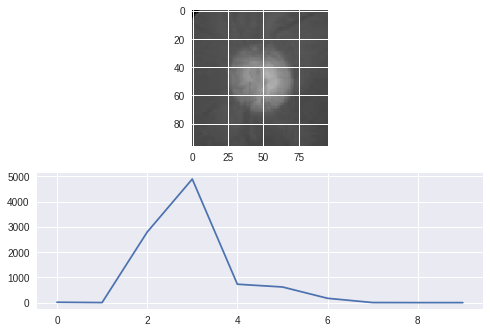

(10, 1)


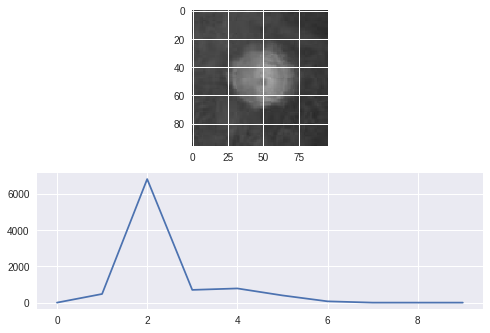

(10, 1)


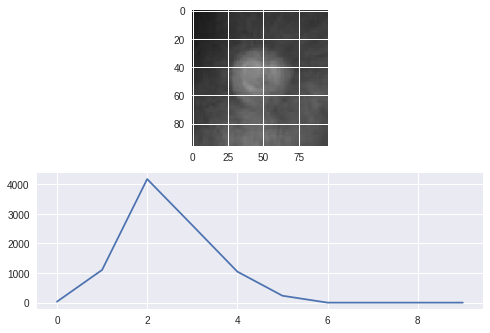

(10, 1)


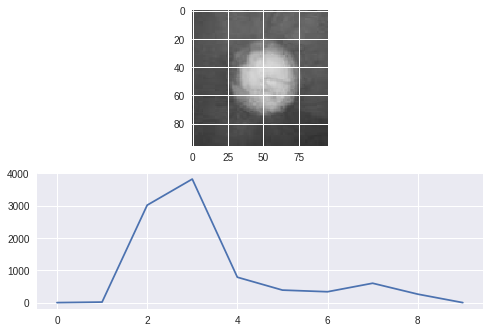

(10, 1)


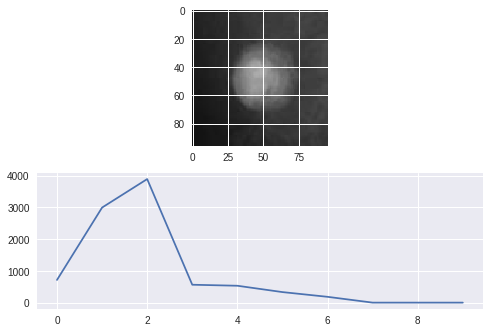

(10, 1)


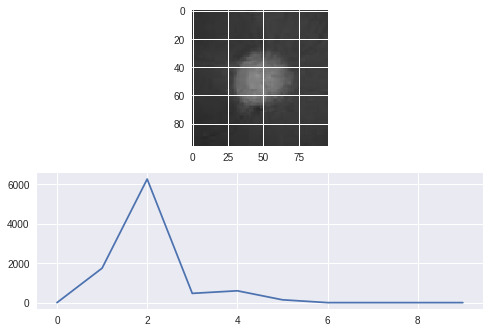

(10, 1)


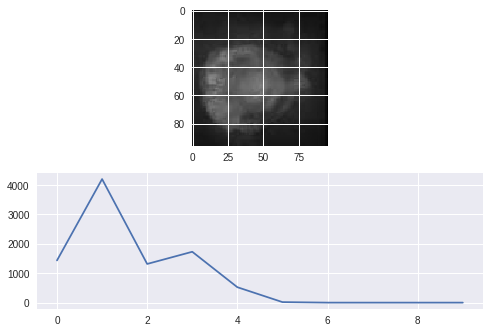

(10, 1)


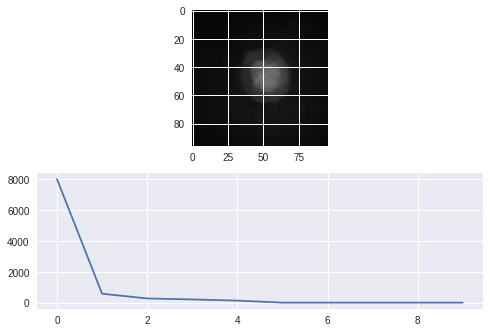

(10, 1)


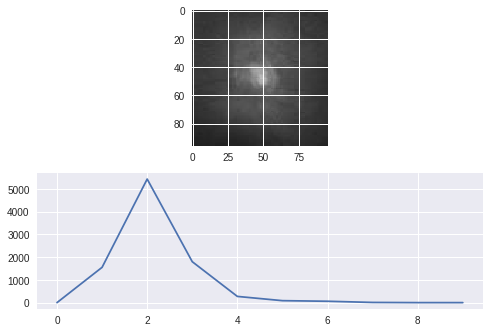

(10, 1)


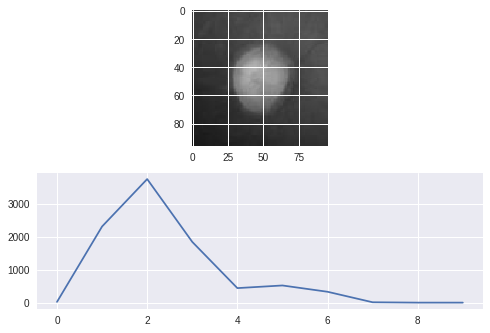

(10, 1)


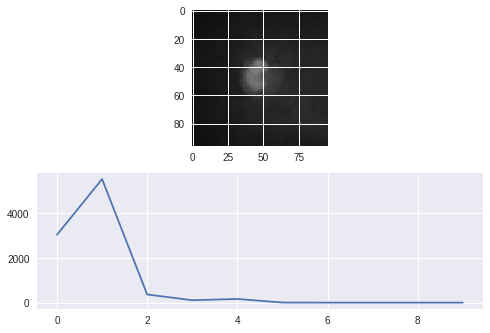

(10, 1)


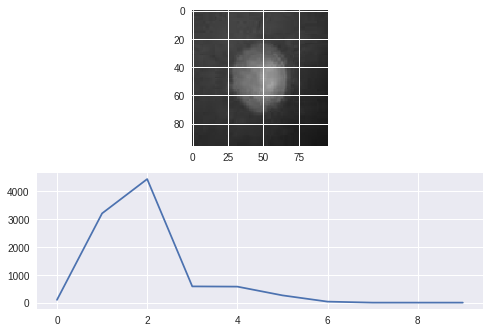

(10, 1)


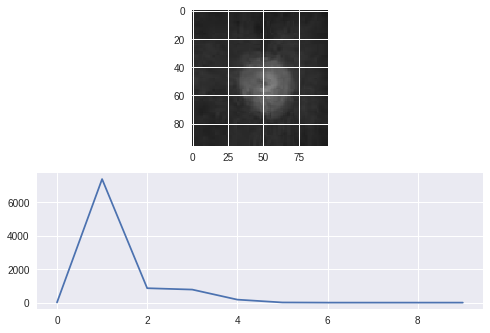

(10, 1)


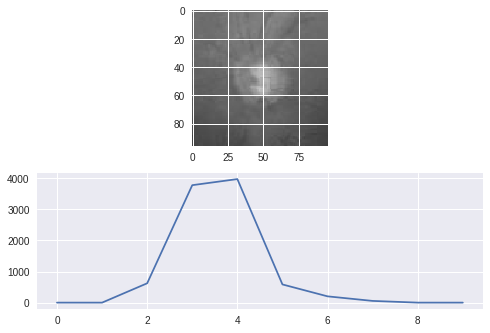

(10, 1)


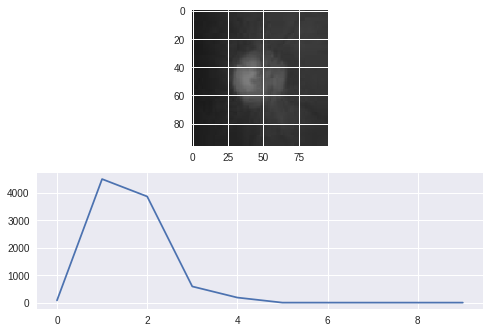

(10, 1)


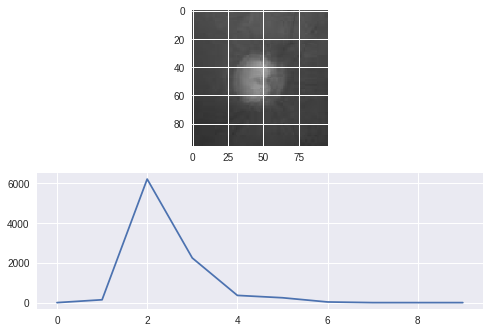

(10, 1)


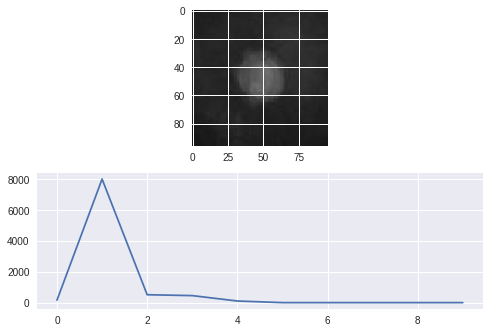

(10, 1)


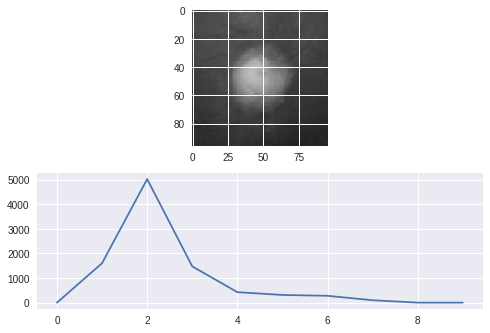

(10, 1)


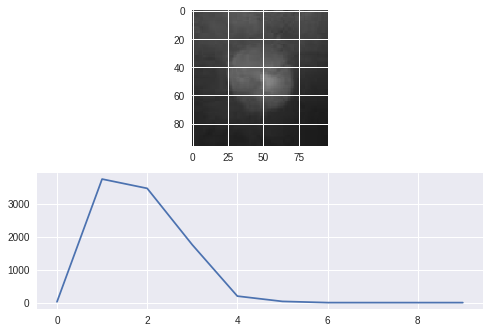

(10, 1)


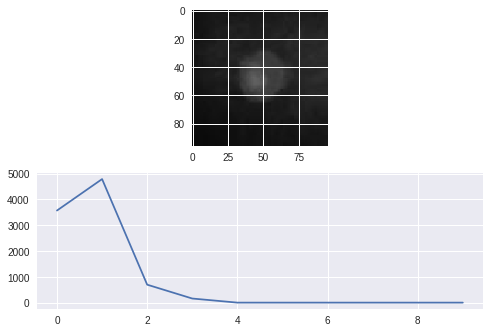

(10, 1)


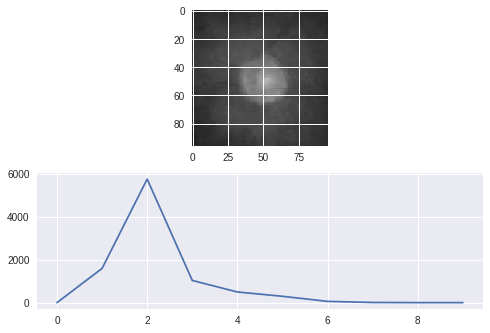

(10, 1)


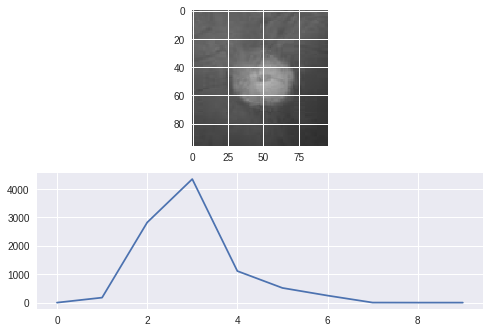

(10, 1)


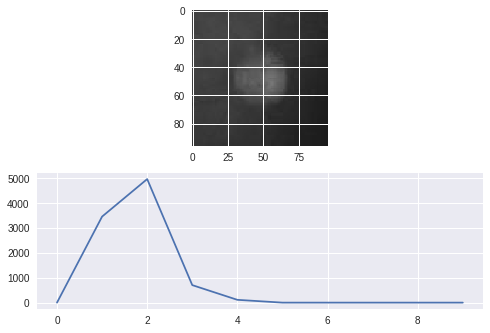

(10, 1)


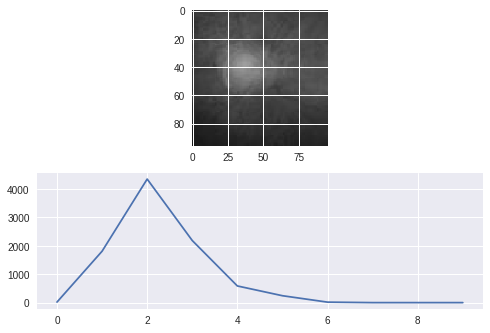

(10, 1)


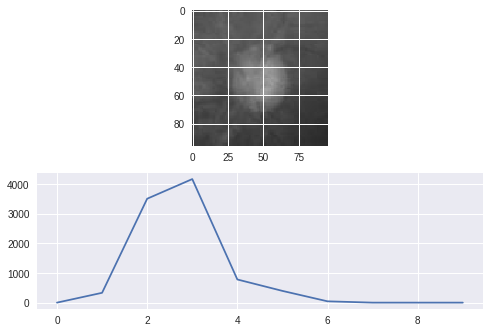

(10, 1)


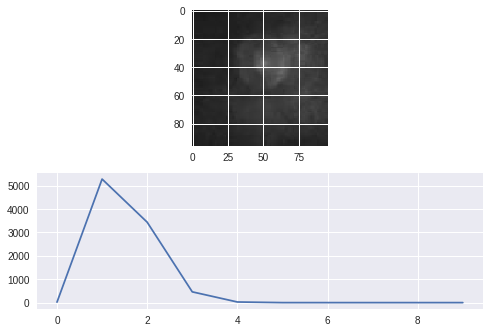

(10, 1)


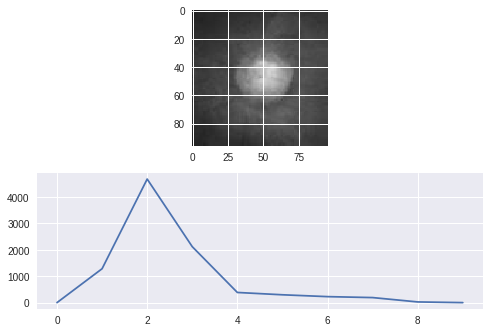

(10, 1)


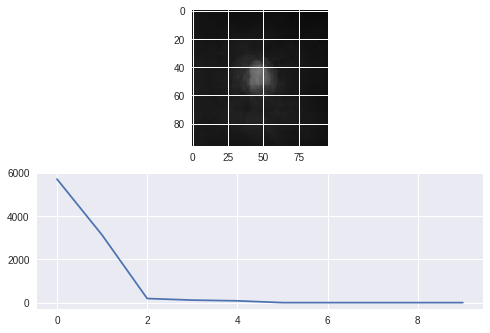

(10, 1)


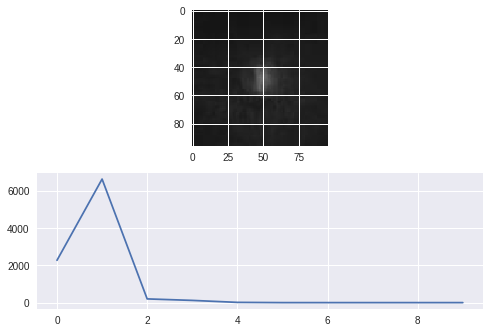

(10, 1)


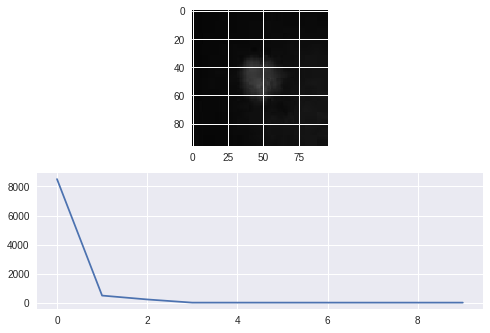

(10, 1)


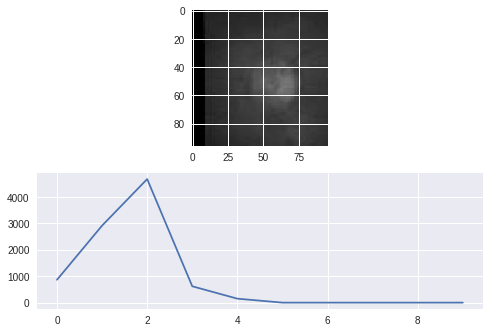

(10, 1)


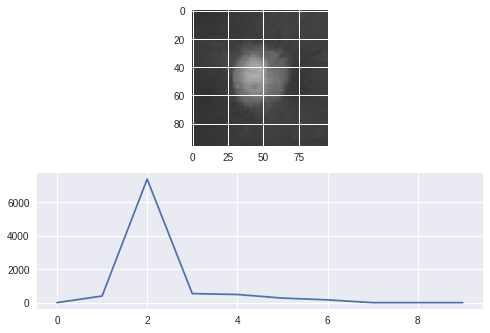

(10, 1)


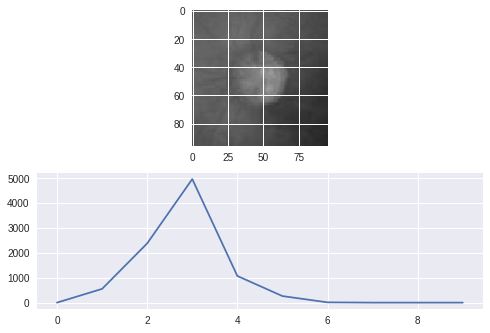

(10, 1)


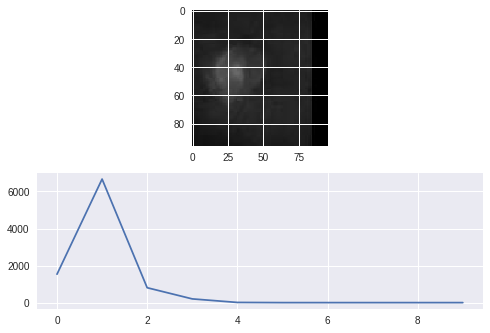

(10, 1)


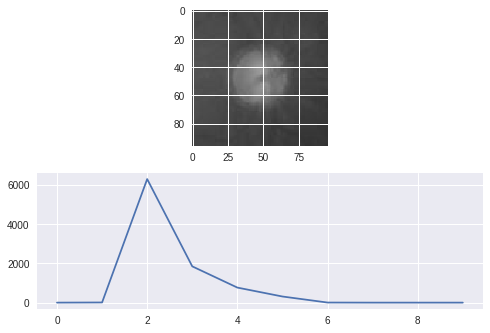

(10, 1)


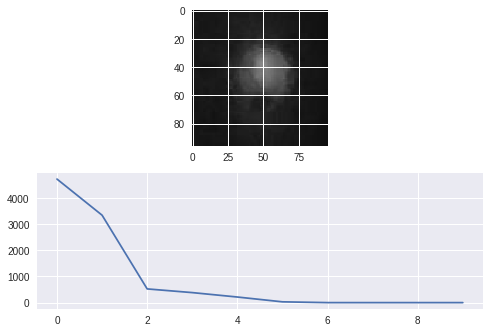

(10, 1)


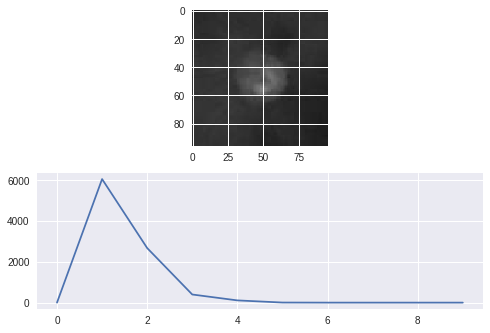

(10, 1)


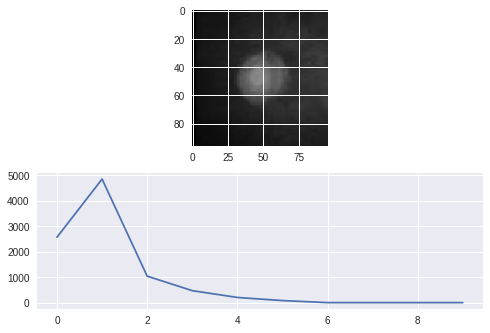

(10, 1)


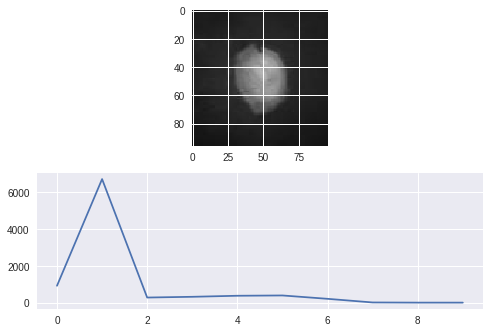

(10, 1)


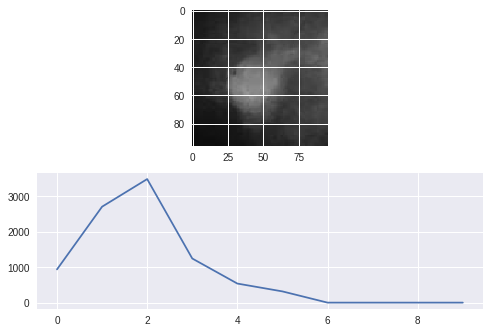

(10, 1)


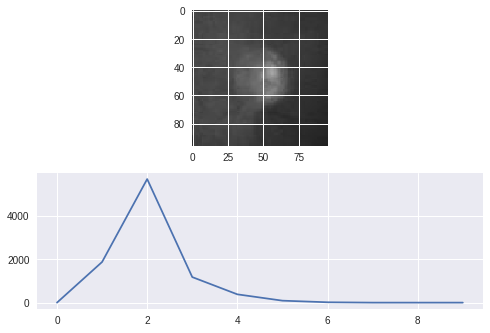

(10, 1)


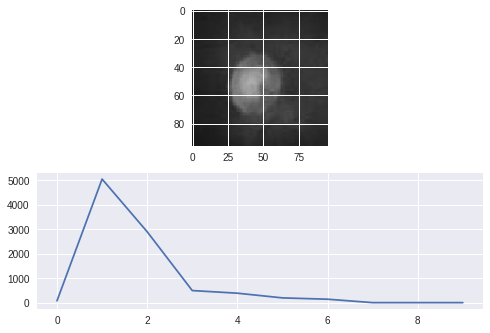

(10, 1)


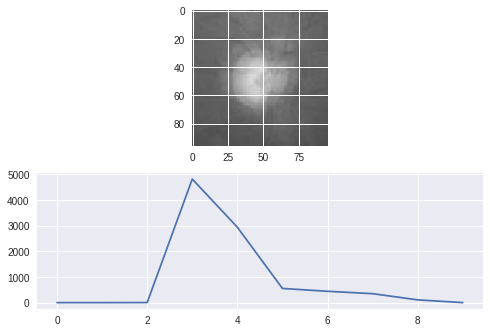

(10, 1)


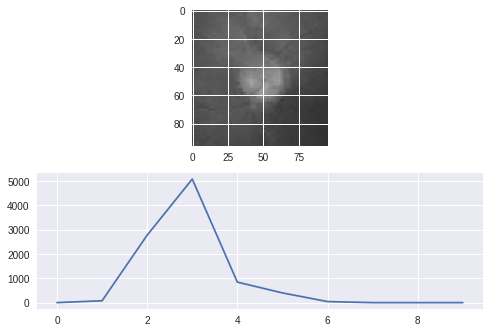

(10, 1)


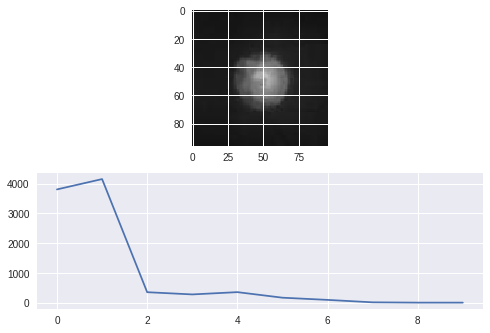

(10, 1)


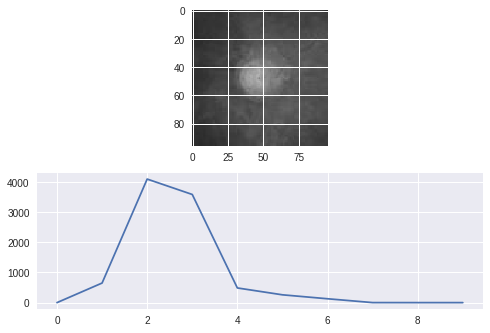

(10, 1)


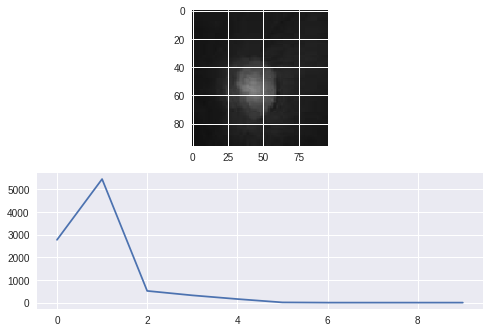

(10, 1)


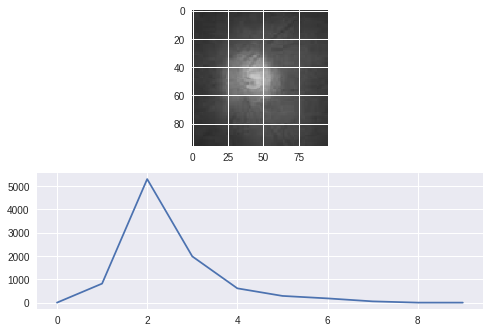

(10, 1)


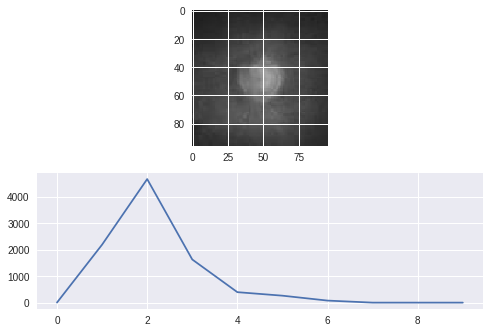

(10, 1)


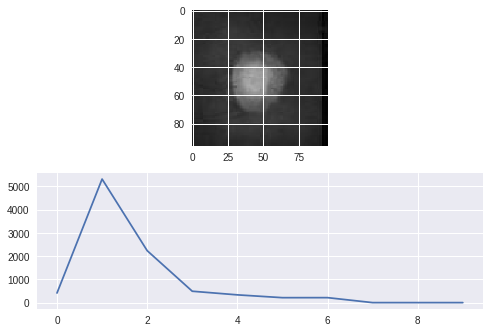

(10, 1)


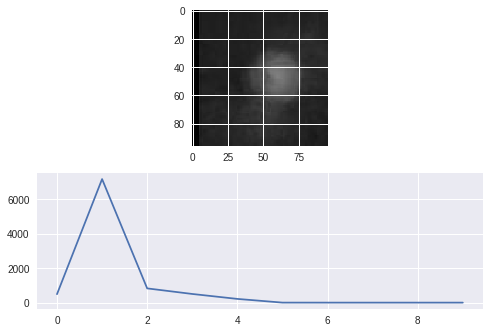

(10, 1)


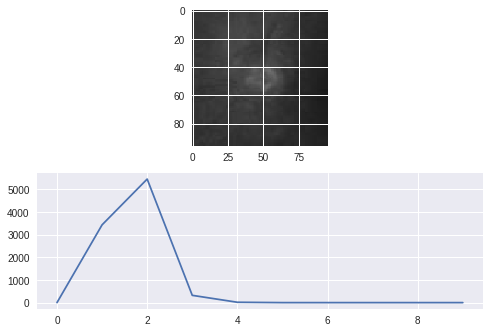

(10, 1)


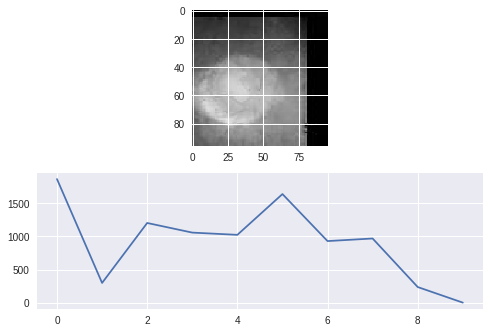

(10, 1)


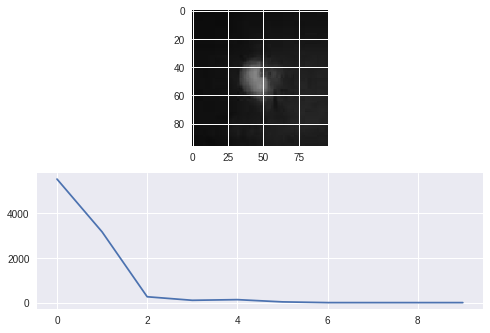

(10, 1)


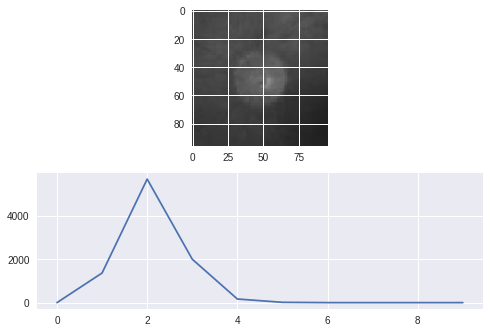

(10, 1)


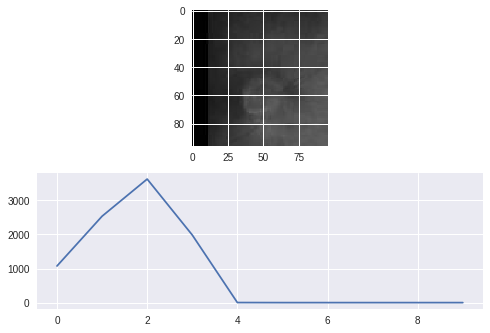

(10, 1)


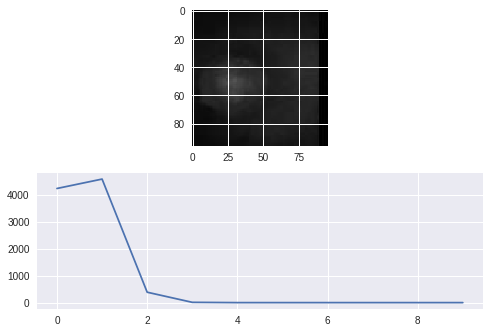

(10, 1)


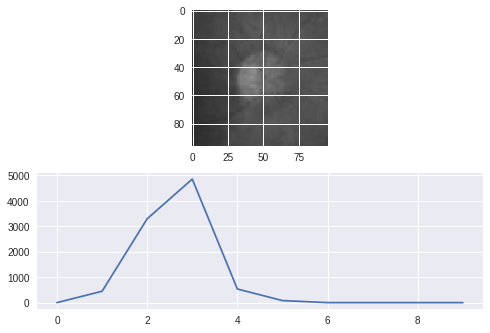

(10, 1)


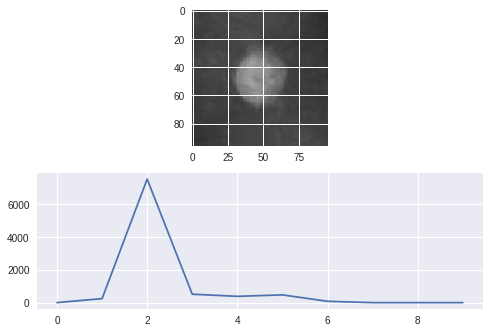

(10, 1)


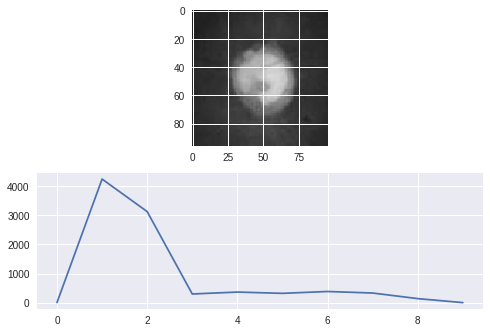

(10, 1)


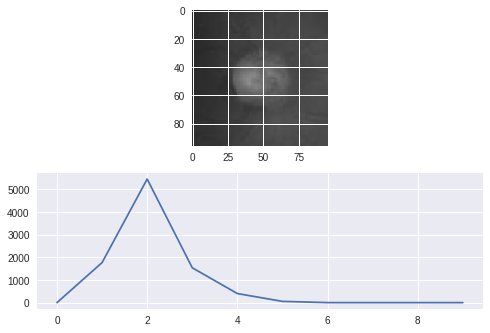

(10, 1)


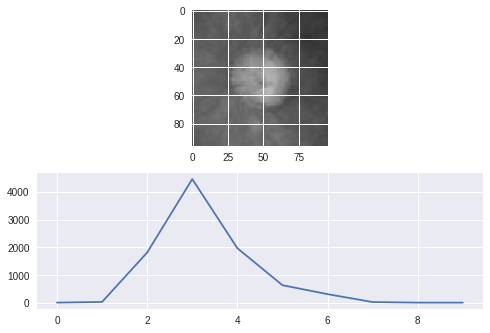

(10, 1)


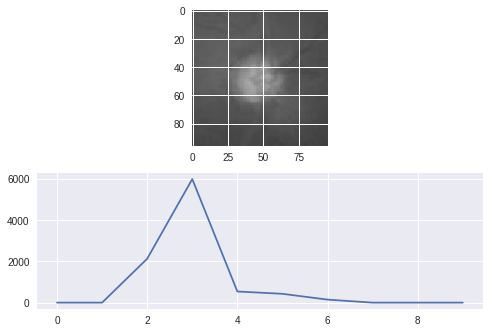

(10, 1)


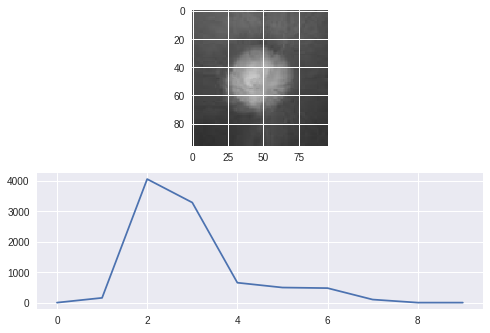

(10, 1)


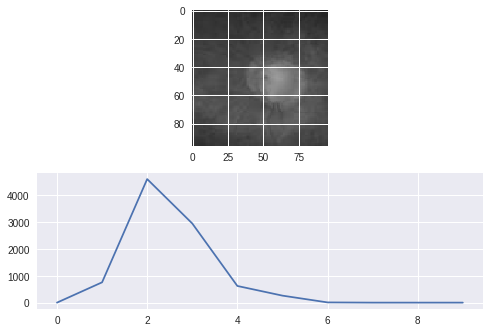

(10, 1)


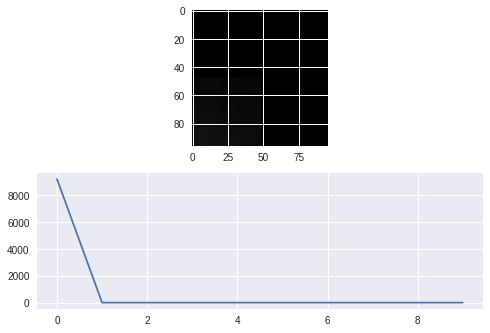

(10, 1)


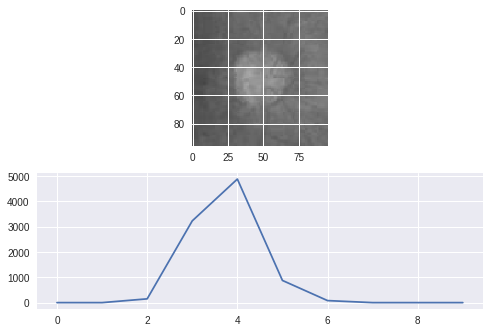

(10, 1)


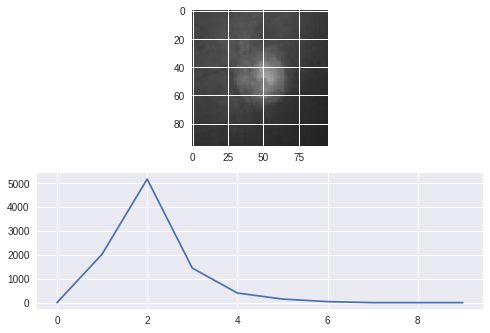

(10, 1)


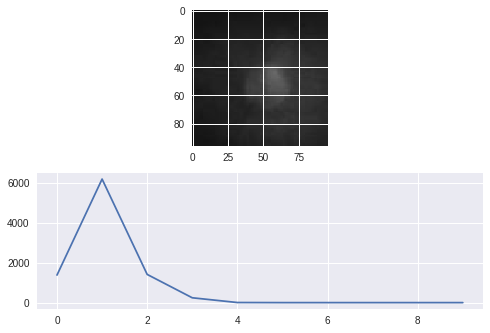

(10, 1)


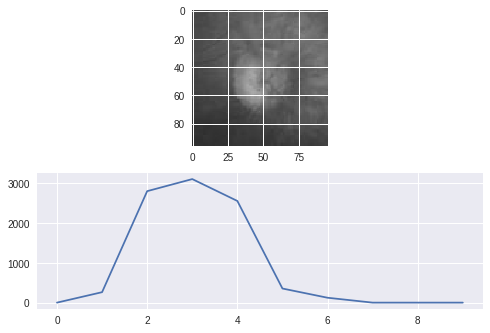

(10, 1)


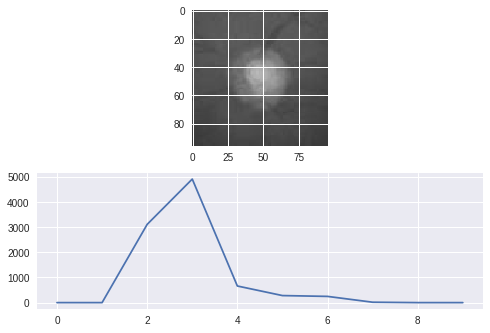

(10, 1)


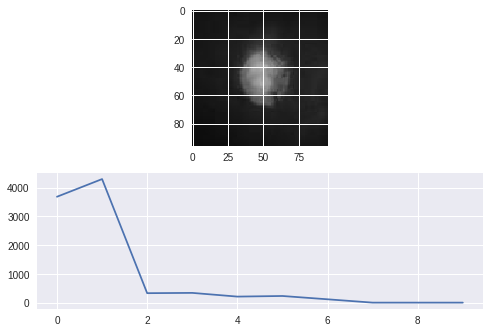

(10, 1)


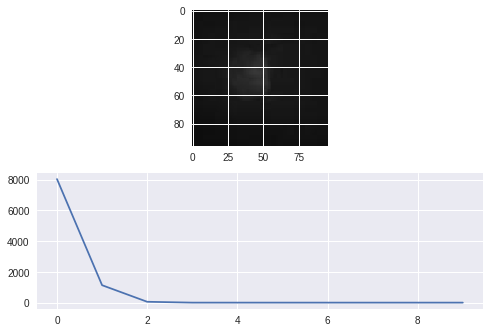

(10, 1)


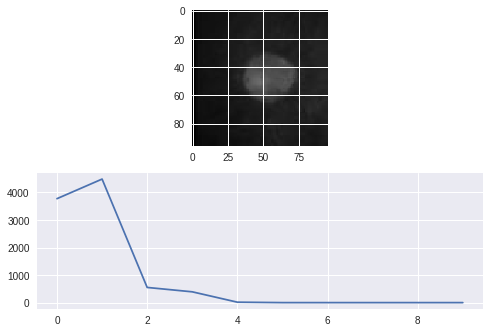

(10, 1)


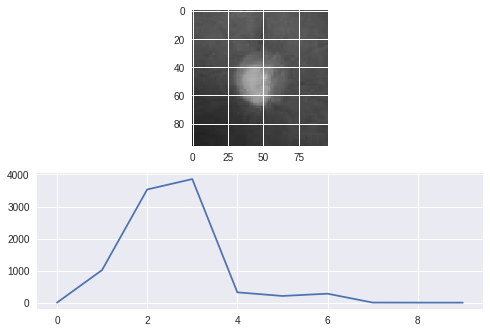

(10, 1)


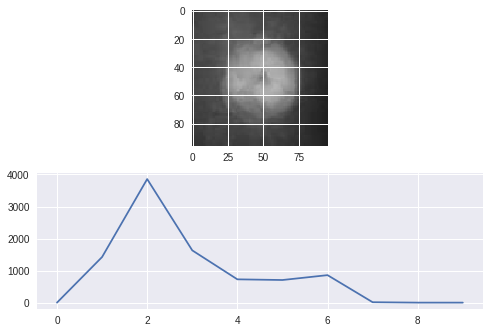

(10, 1)


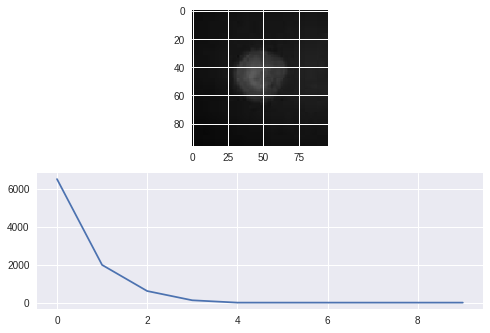

(10, 1)


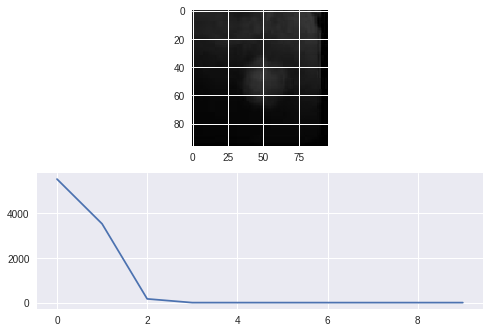

(10, 1)


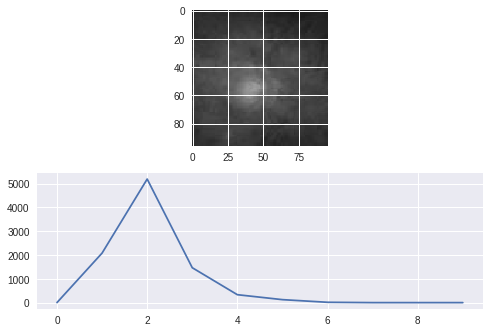

(10, 1)


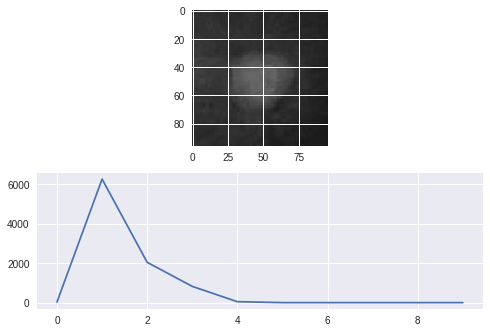

(10, 1)


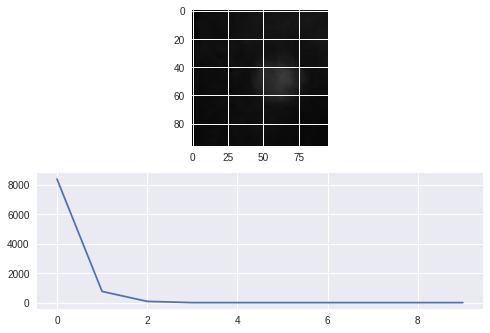

(10, 1)


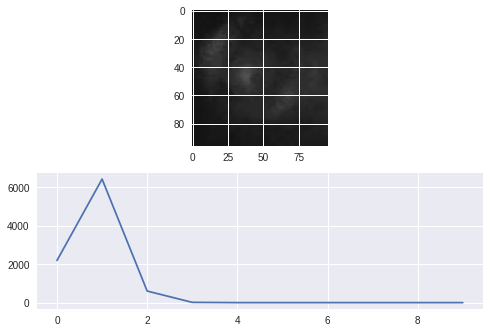

(10, 1)


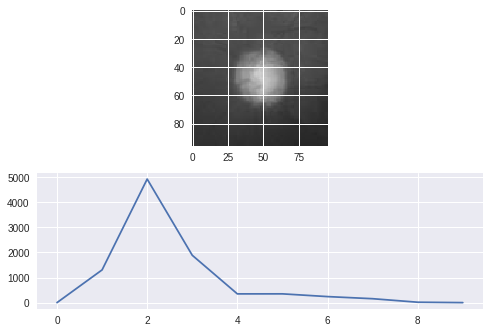

(10, 1)


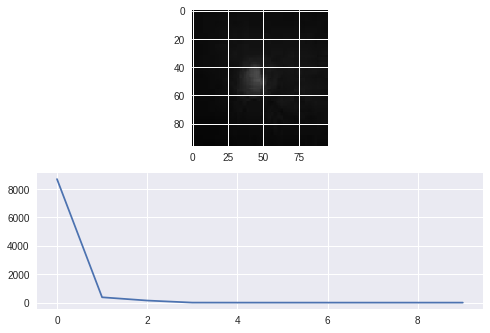

(10, 1)


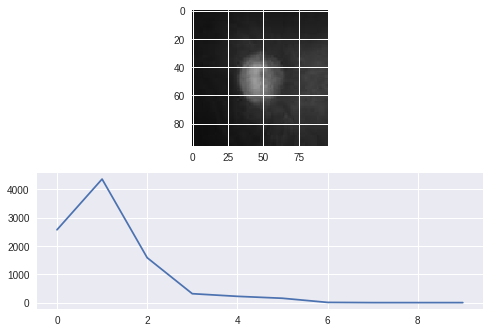

(10, 1)


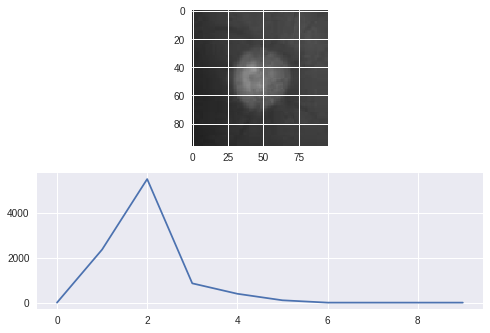

(10, 1)


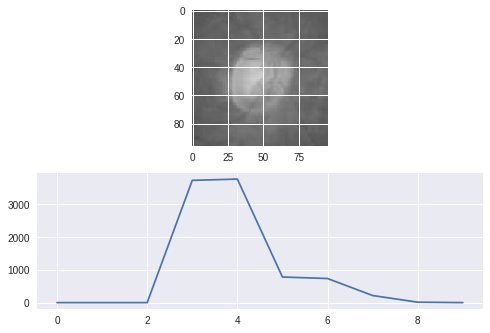

(10, 1)


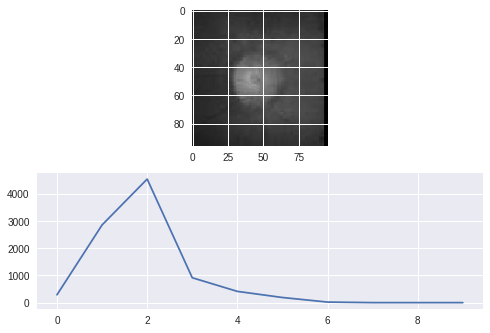

(10, 1)


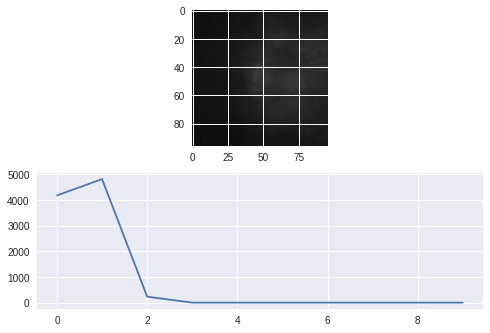

(10, 1)


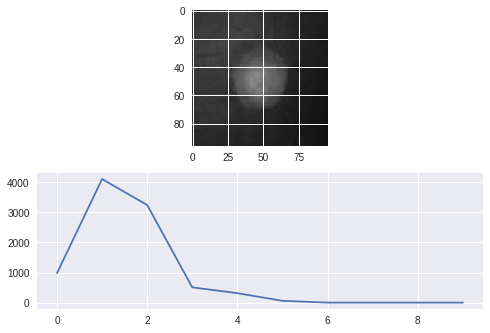

(10, 1)


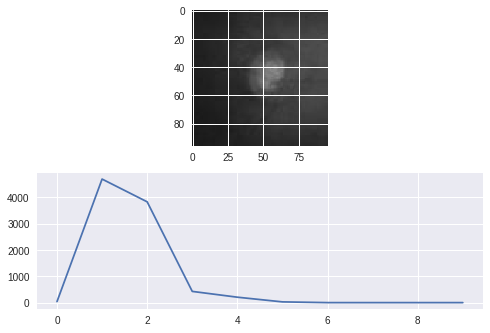

(10, 1)


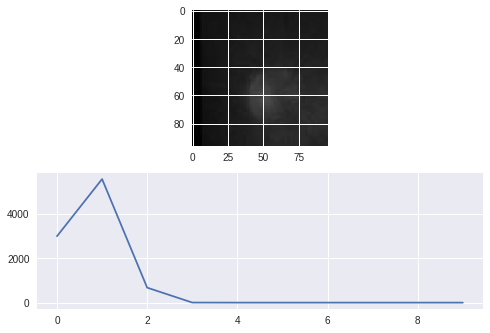

(10, 1)


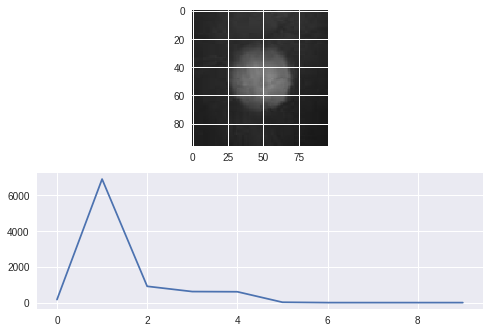

(10, 1)


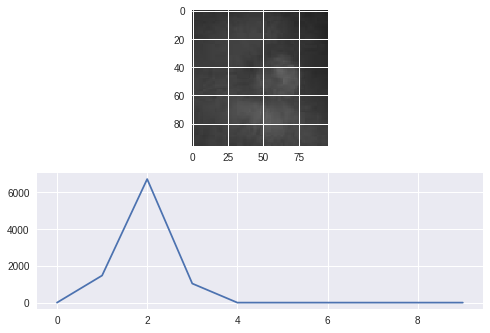

(10, 1)


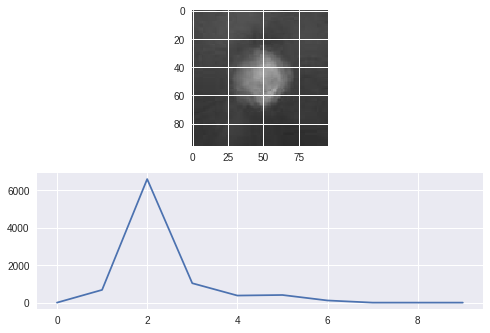

(10, 1)


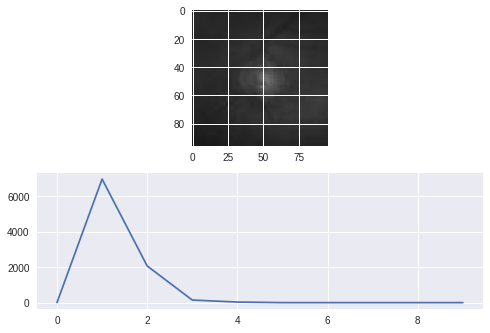

(10, 1)


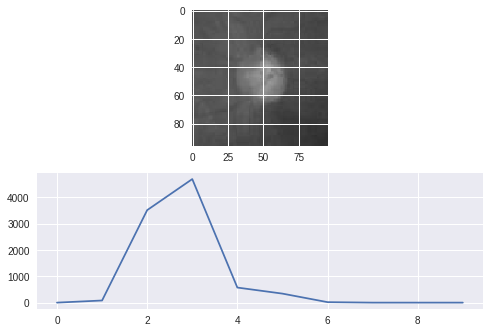

(10, 1)


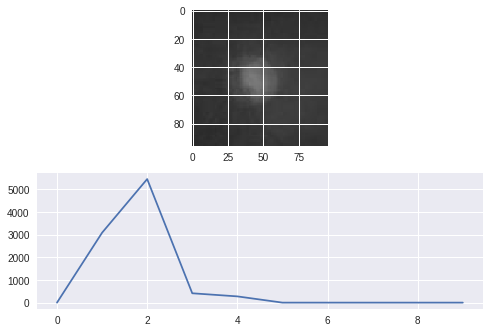

(10, 1)


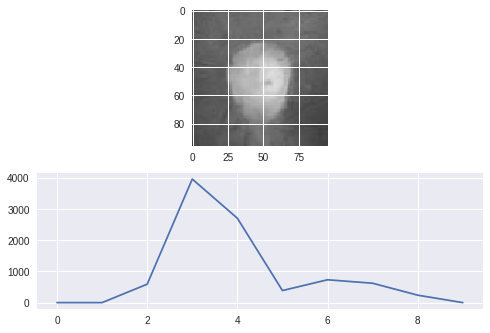

(10, 1)


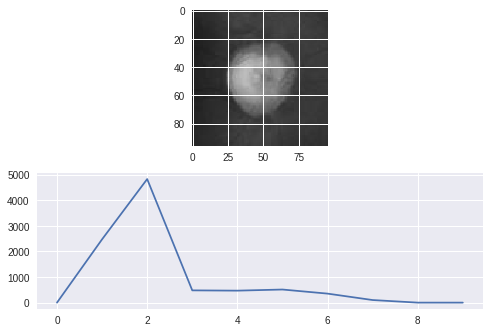

(10, 1)


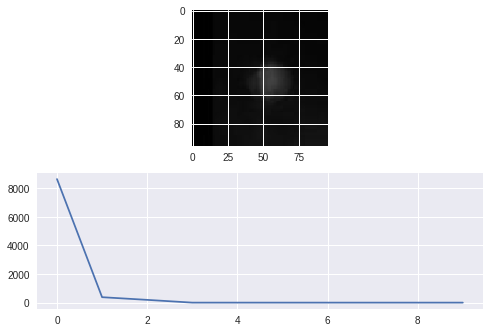

(10, 1)


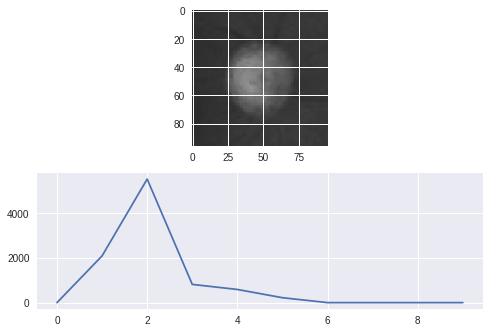

(10, 1)


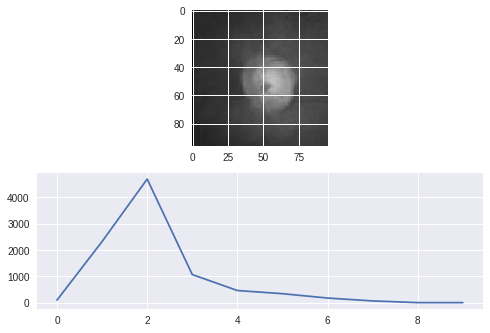

(10, 1)


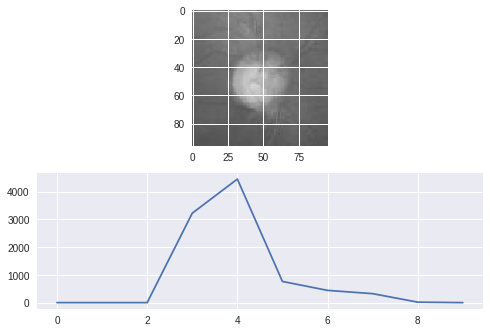

(10, 1)


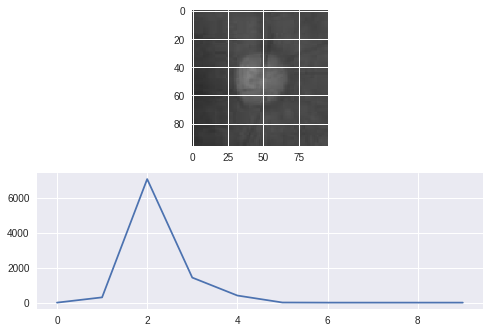

(10, 1)


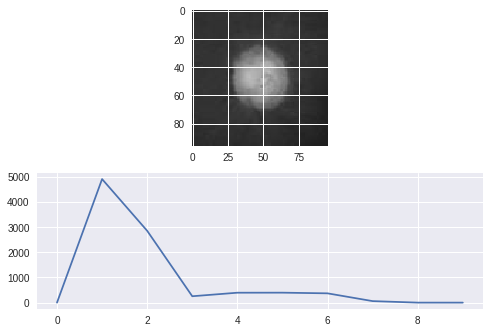

(10, 1)


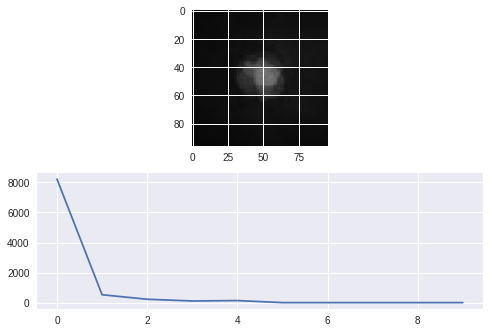

(10, 1)


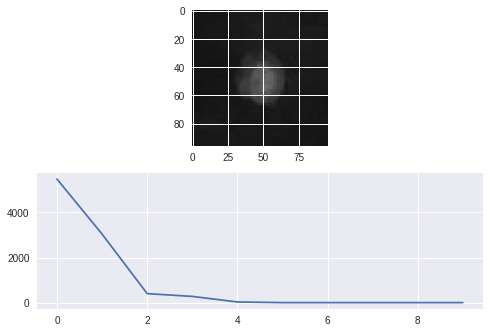

In [34]:
# find frequency of pixels in range 0-255
histograms = {}
i = 1
for n in os.listdir("PUBLIC_FUNDUS/glaucoma"):
  n = cv2.imread("PUBLIC_FUNDUS/glaucoma/"+n)
  f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[10],[0,255])
  axarr[0].imshow(n)
  print(histr.shape)
  # show the plotting graph of an image
  axarr[1].plot(histr)
  plt.show()


(50, 1)


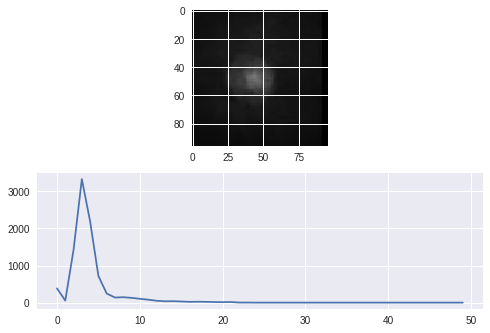

(50, 1)


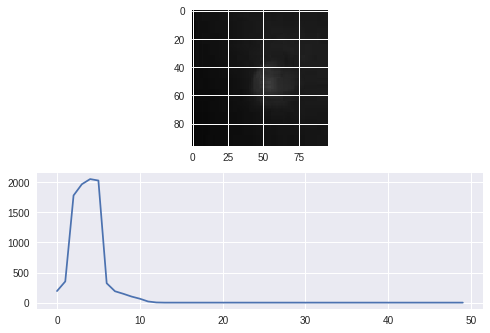

(50, 1)


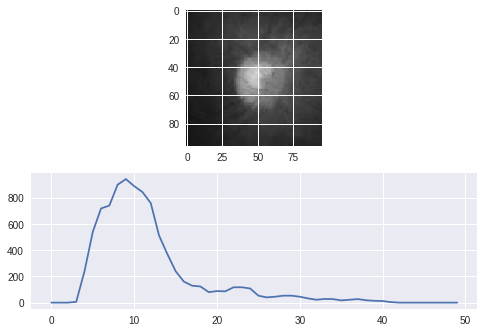

(50, 1)


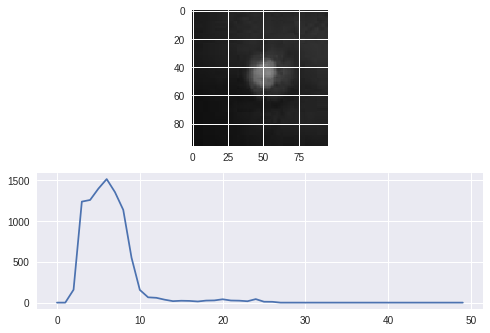

(50, 1)


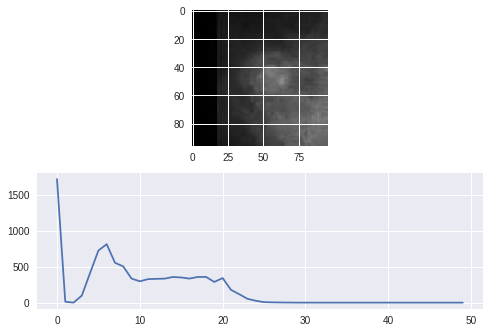

(50, 1)


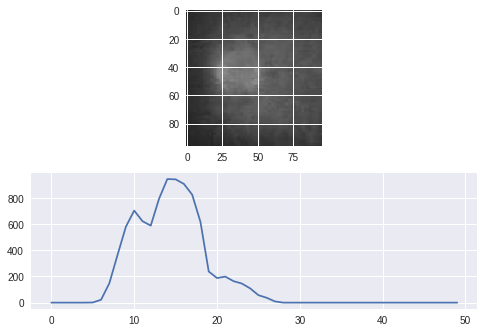

(50, 1)


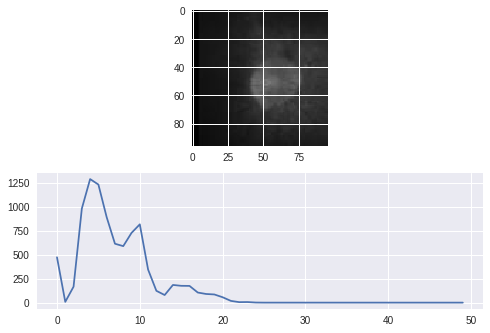

(50, 1)


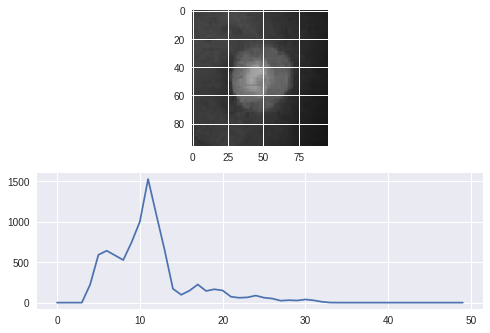

(50, 1)


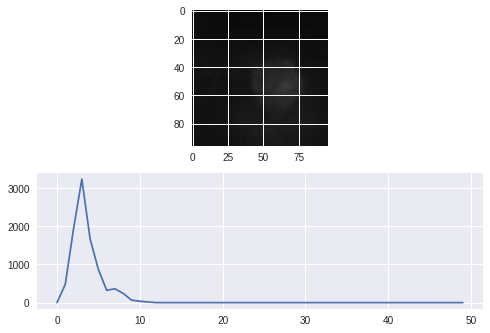

(50, 1)


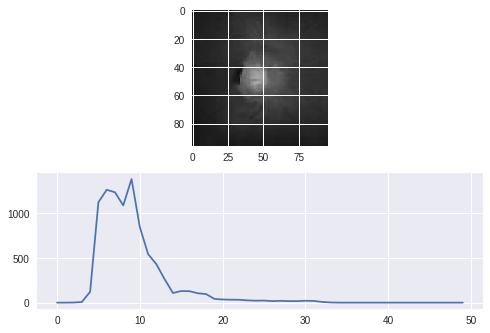

(50, 1)


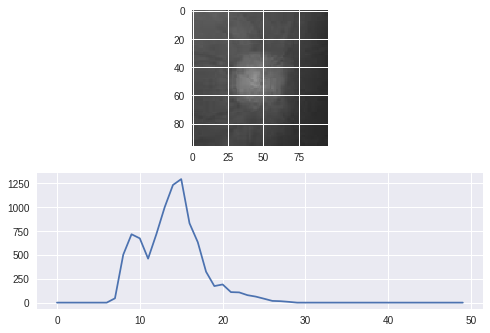

(50, 1)


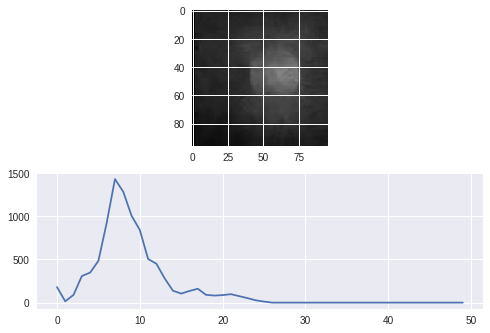

(50, 1)


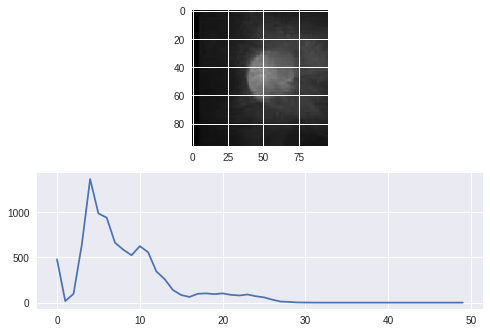

(50, 1)


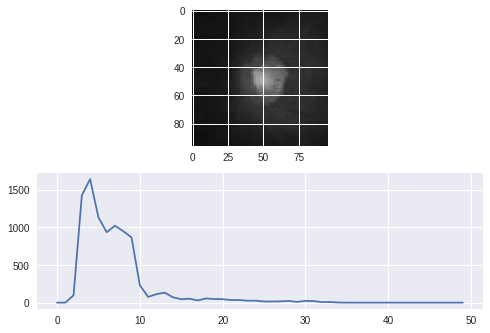

(50, 1)


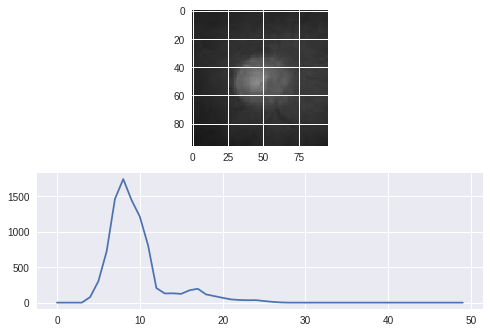

(50, 1)


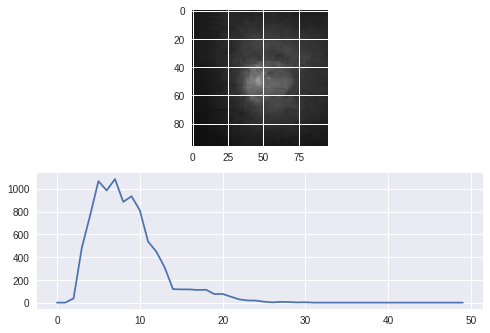

(50, 1)


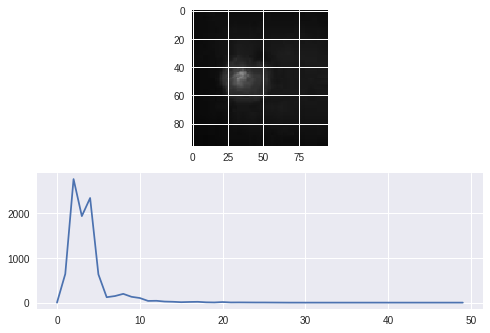

(50, 1)


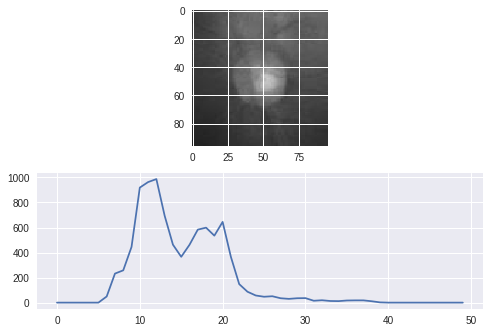

(50, 1)


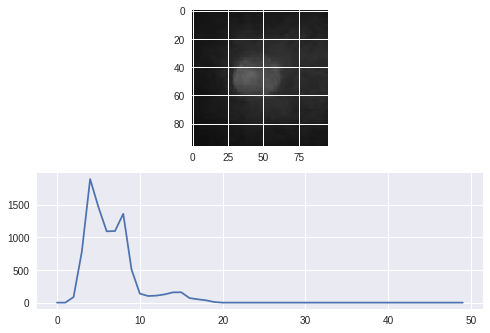

(50, 1)


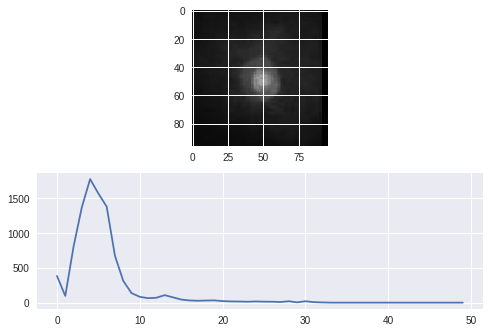

(50, 1)


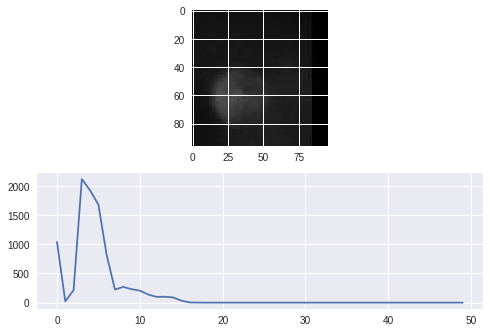

(50, 1)


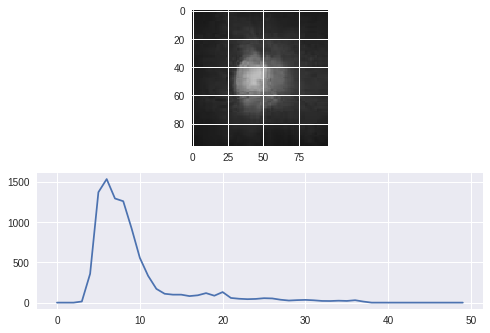

(50, 1)


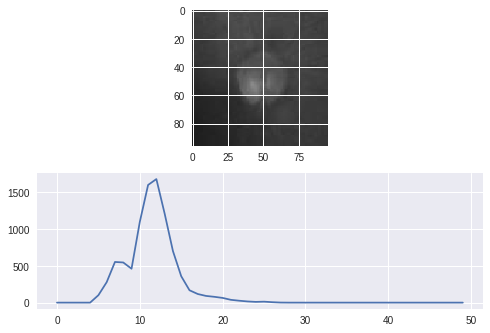

(50, 1)


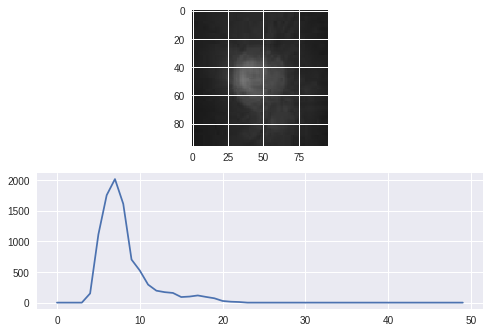

(50, 1)


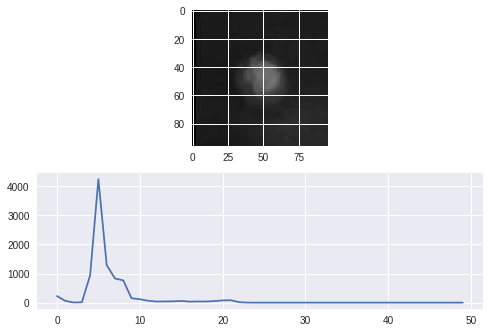

(50, 1)


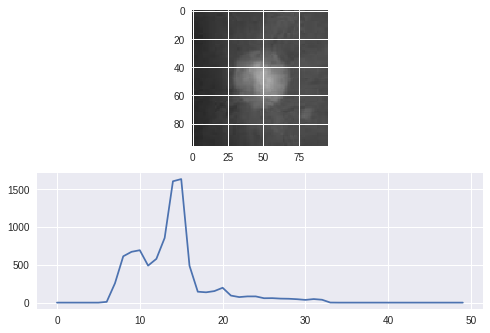

(50, 1)


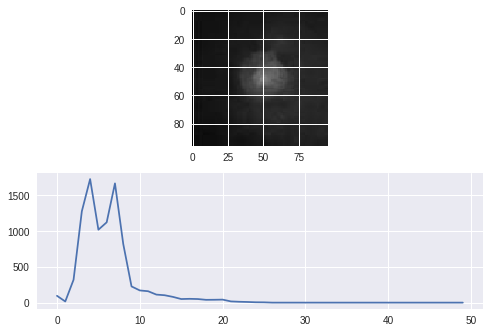

(50, 1)


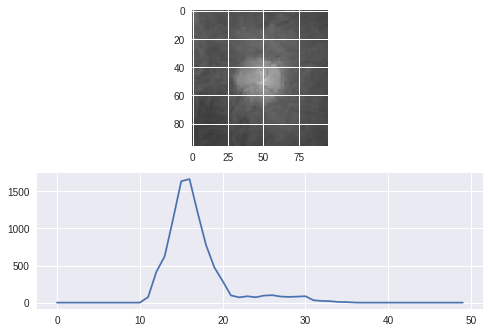

(50, 1)


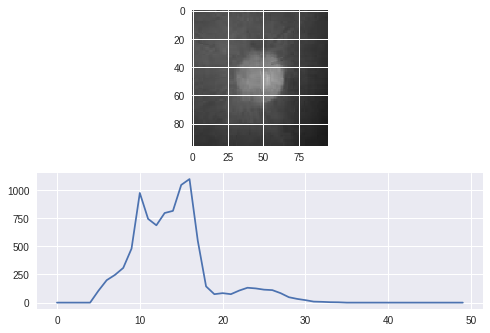

(50, 1)


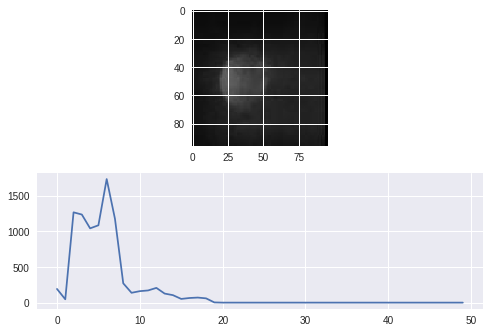

(50, 1)


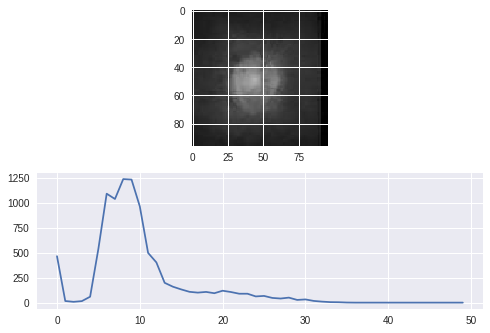

(50, 1)


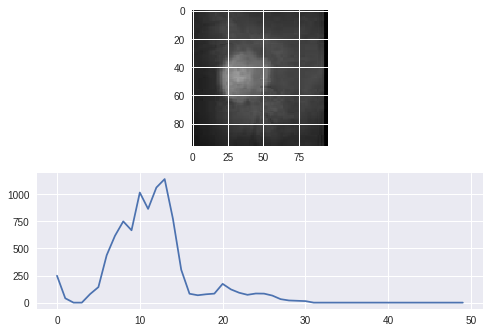

(50, 1)


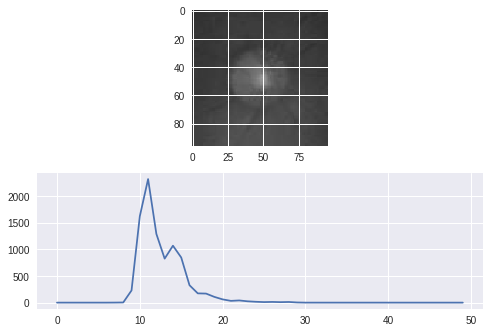

(50, 1)


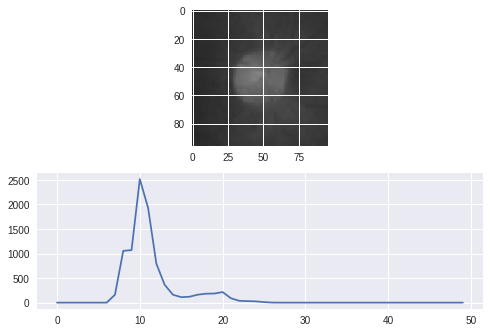

(50, 1)


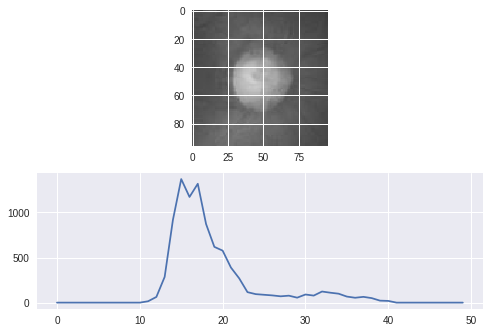

(50, 1)


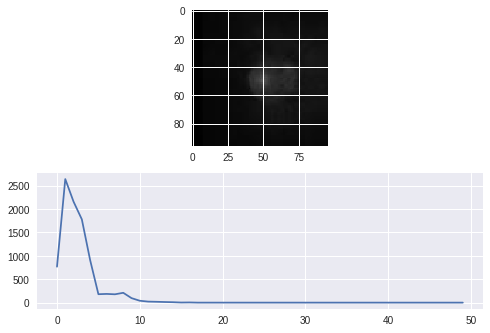

(50, 1)


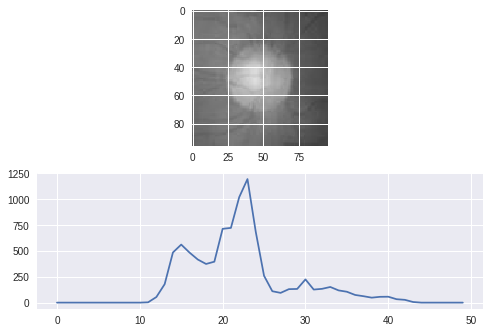

(50, 1)


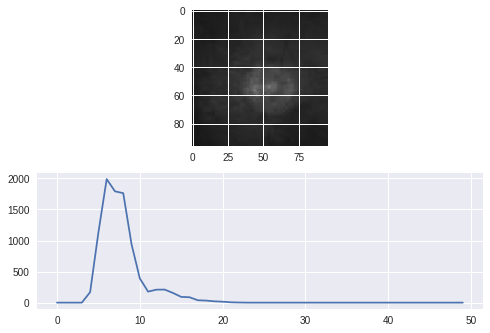

(50, 1)


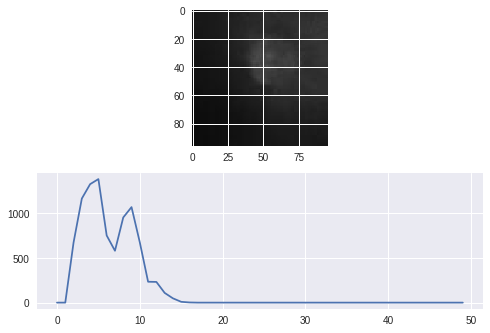

(50, 1)


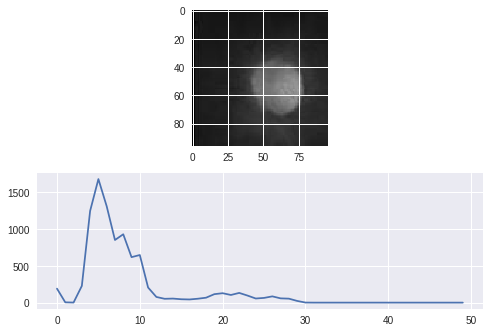

(50, 1)


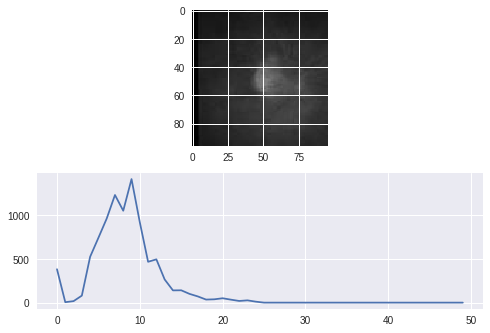

(50, 1)


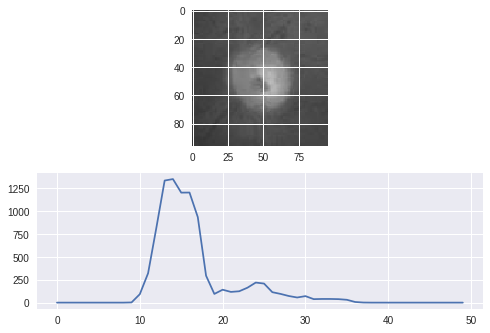

(50, 1)


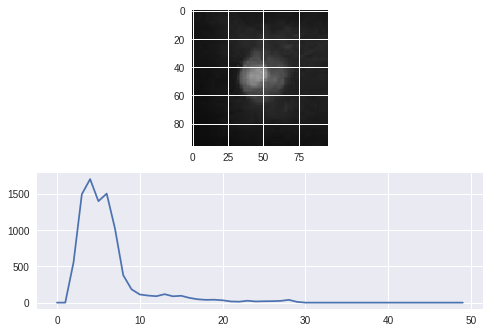

(50, 1)


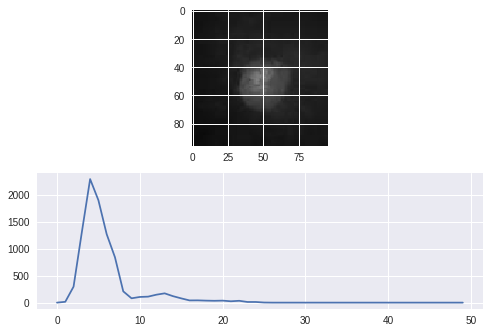

(50, 1)


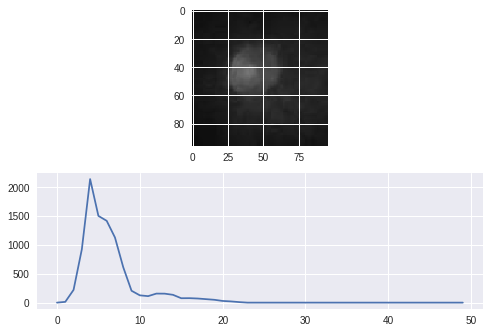

(50, 1)


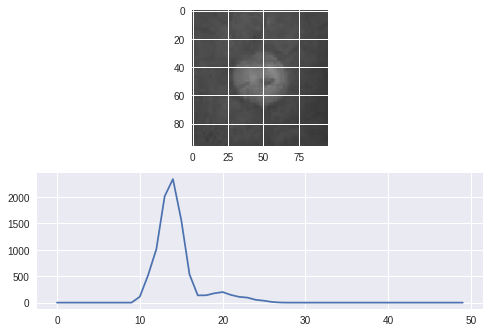

(50, 1)


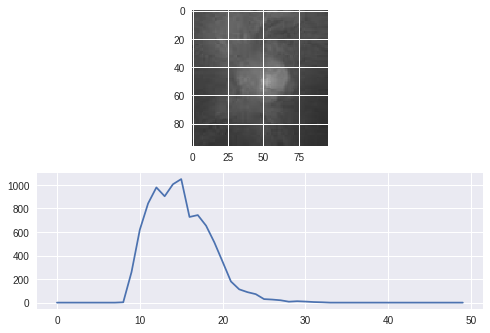

(50, 1)


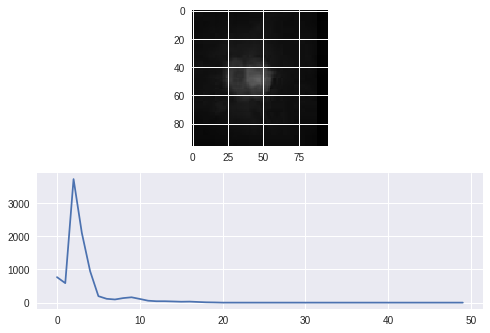

(50, 1)


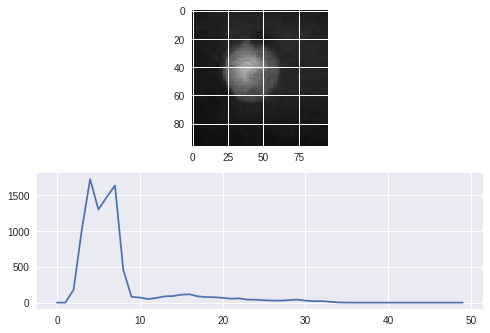

(50, 1)


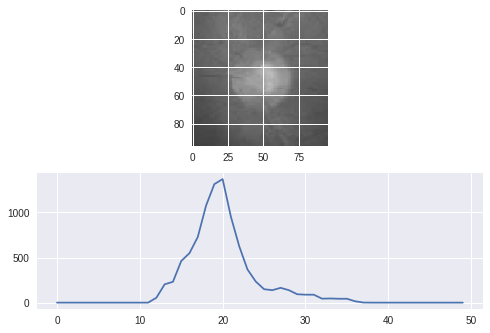

(50, 1)


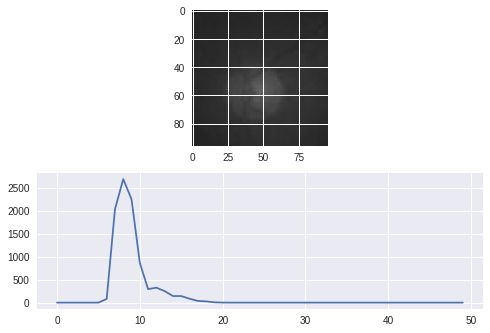

(50, 1)


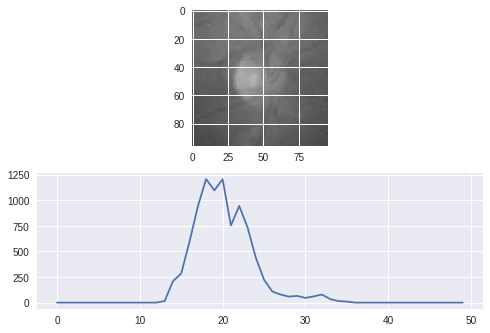

(50, 1)


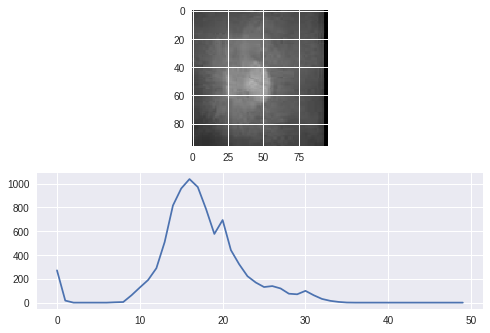

(50, 1)


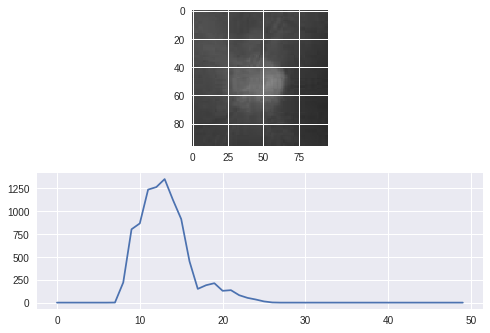

(50, 1)


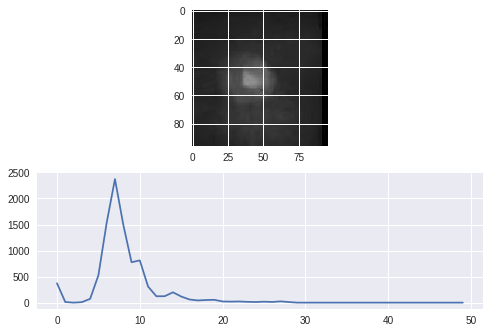

(50, 1)


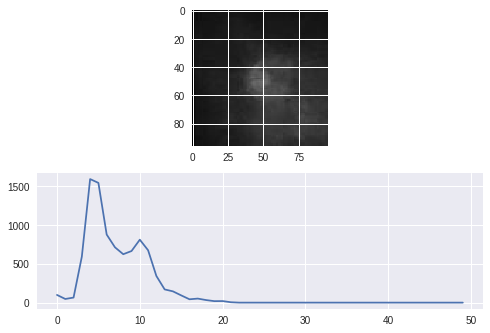

(50, 1)


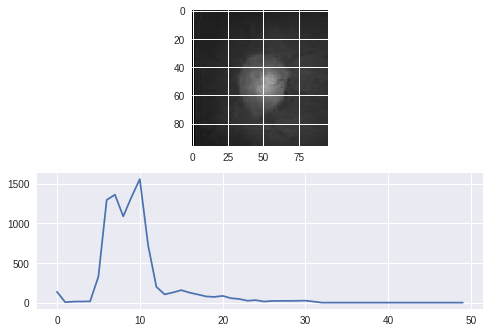

(50, 1)


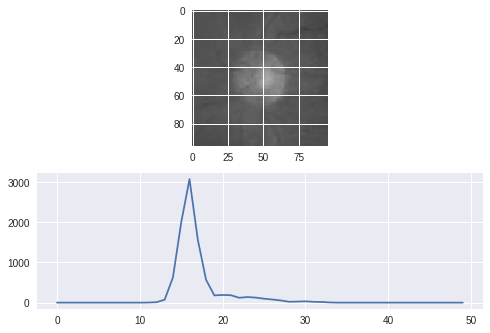

(50, 1)


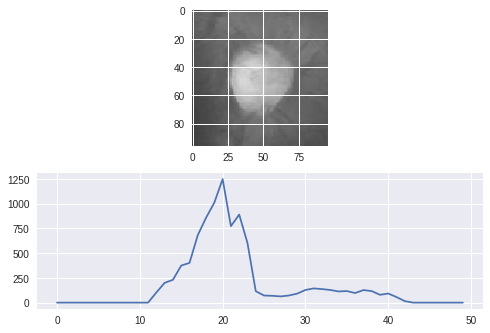

(50, 1)


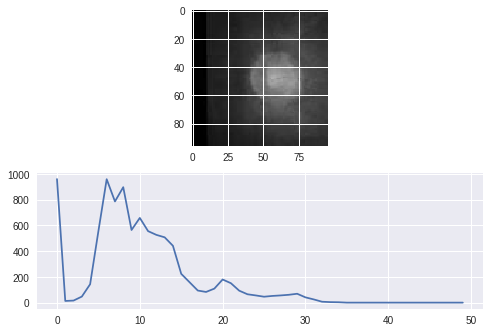

(50, 1)


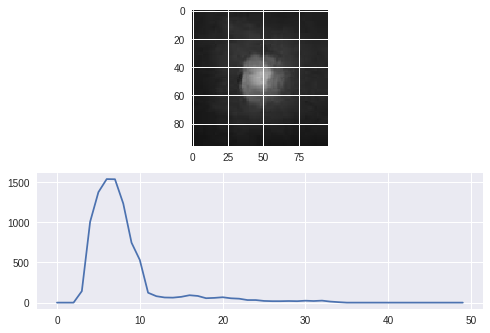

(50, 1)


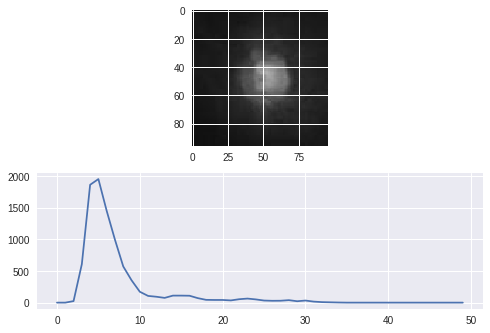

(50, 1)


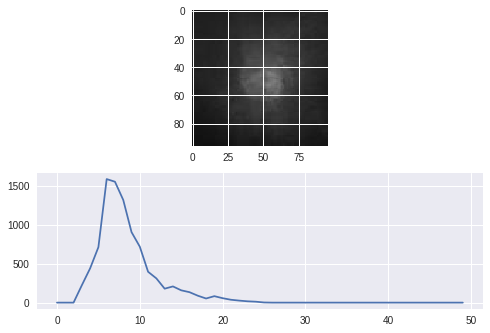

(50, 1)


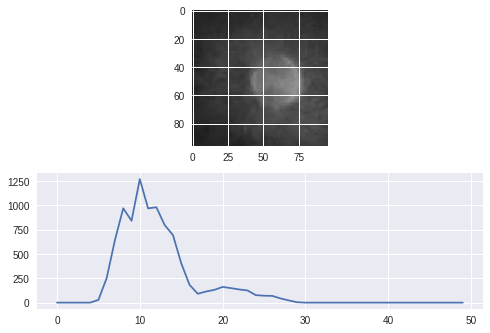

(50, 1)


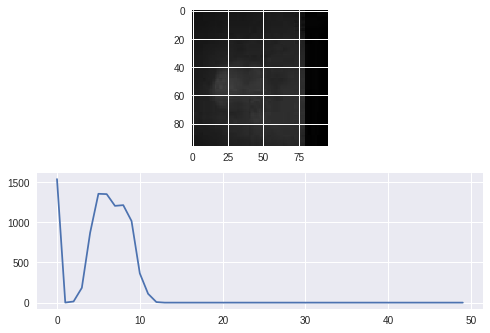

(50, 1)


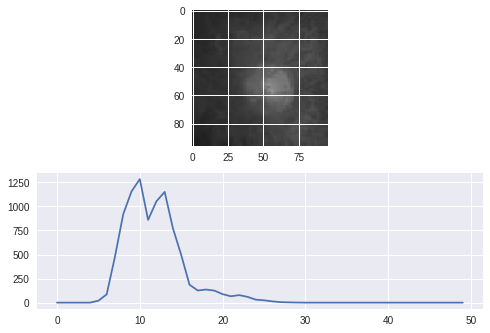

(50, 1)


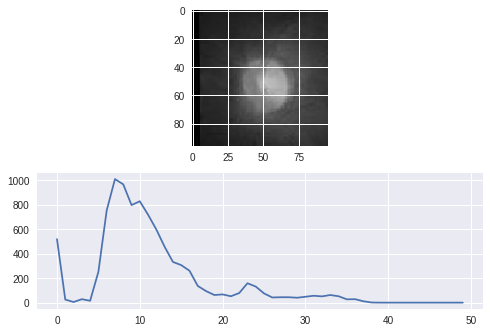

(50, 1)


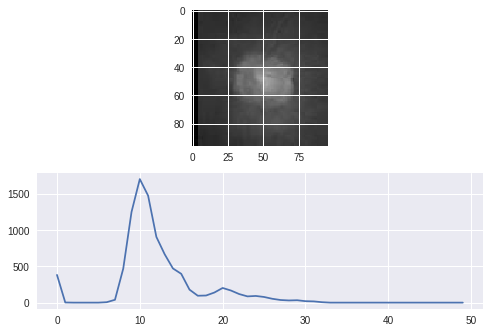

(50, 1)


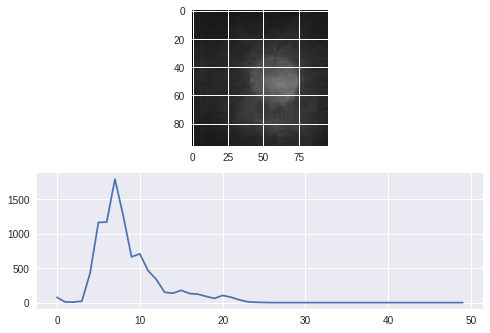

(50, 1)


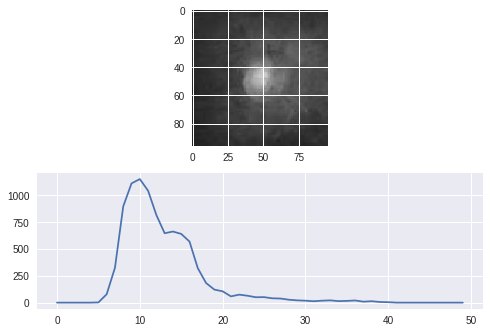

(50, 1)


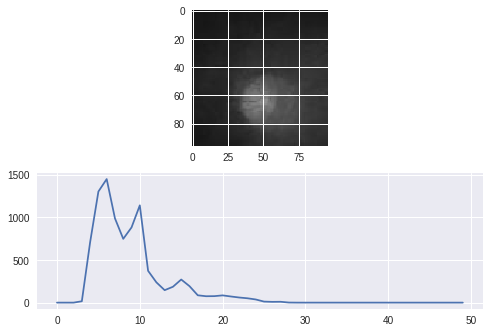

(50, 1)


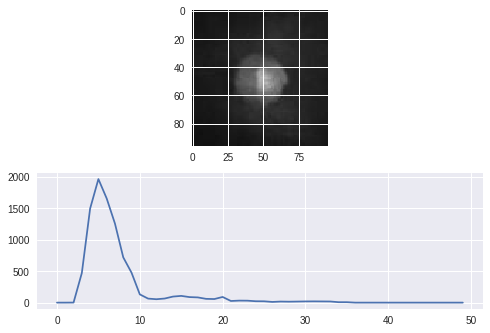

(50, 1)


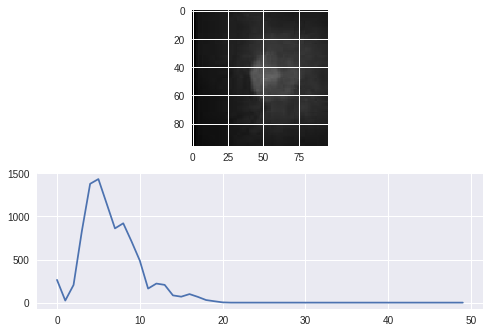

(50, 1)


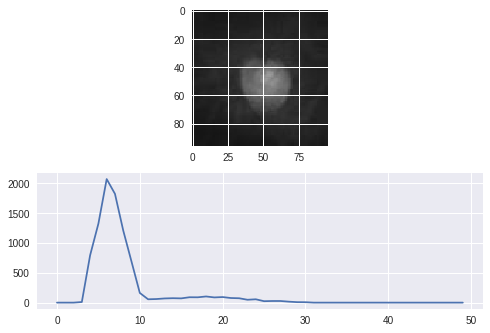

(50, 1)


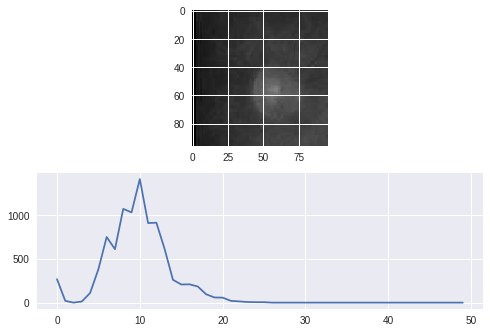

(50, 1)


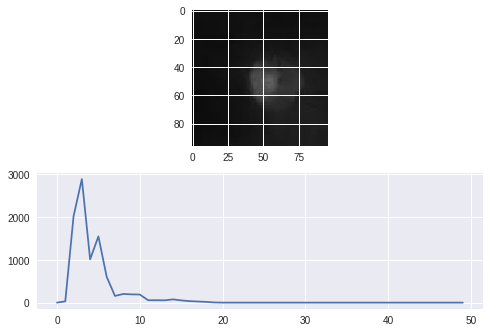

(50, 1)


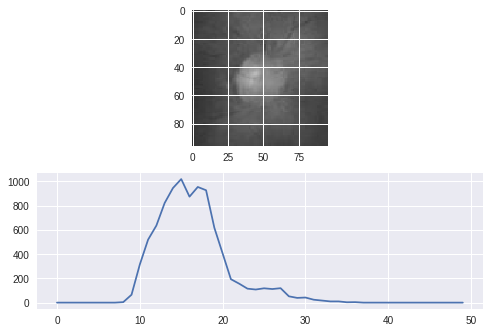

(50, 1)


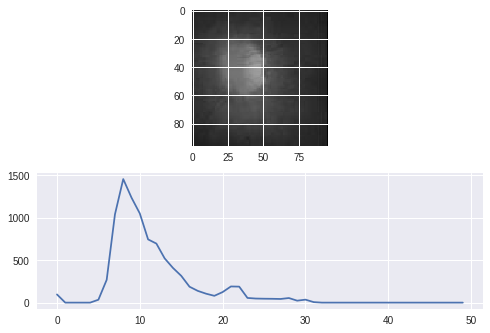

(50, 1)


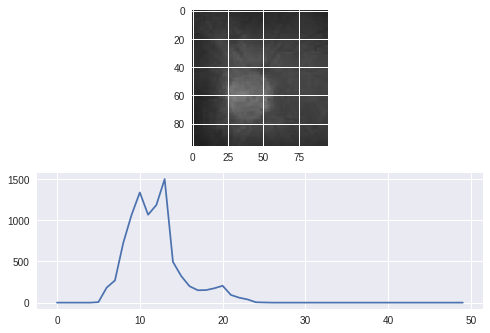

(50, 1)


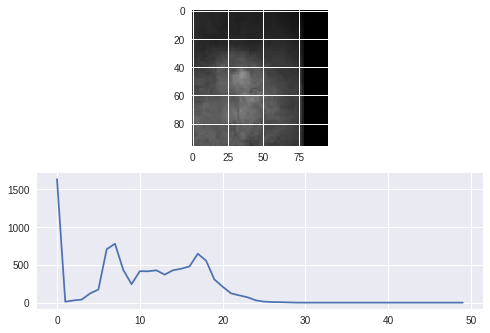

(50, 1)


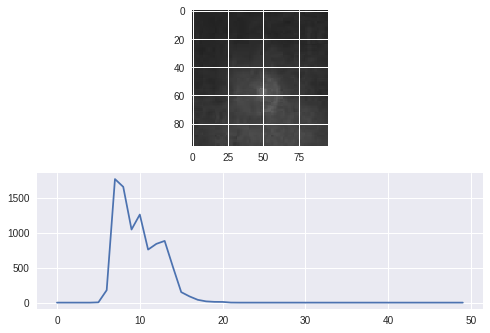

(50, 1)


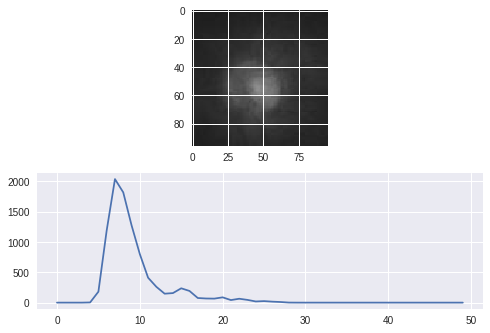

(50, 1)


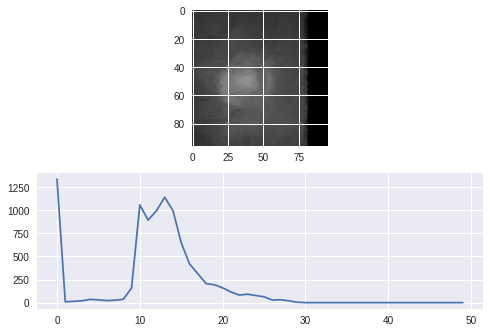

(50, 1)


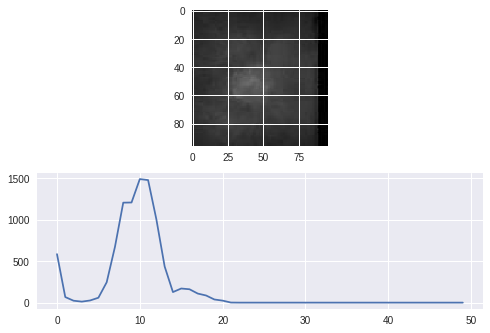

(50, 1)


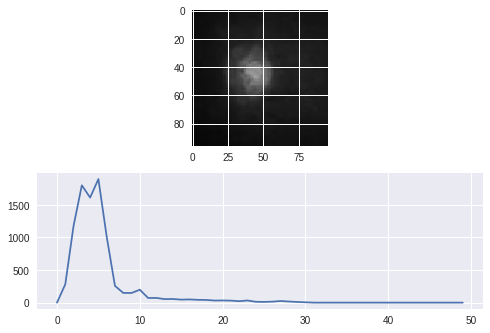

(50, 1)


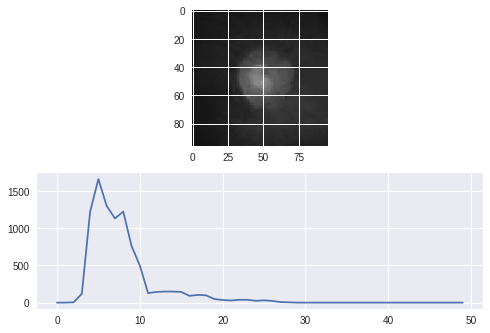

(50, 1)


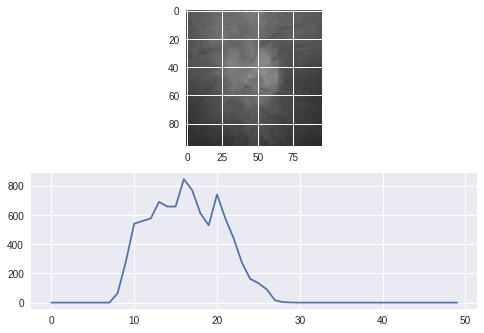

(50, 1)


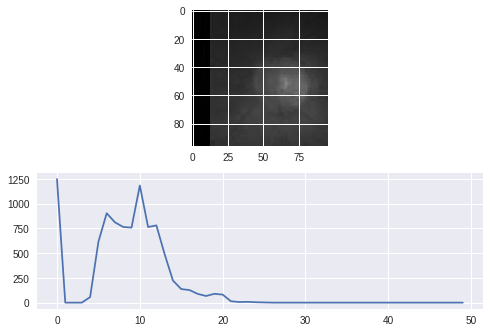

(50, 1)


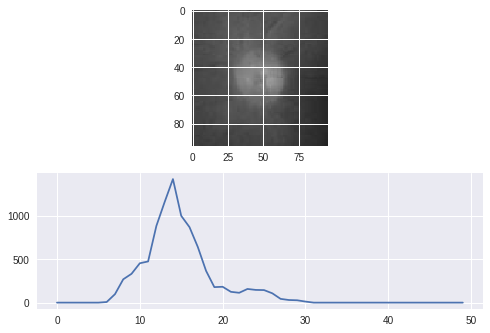

(50, 1)


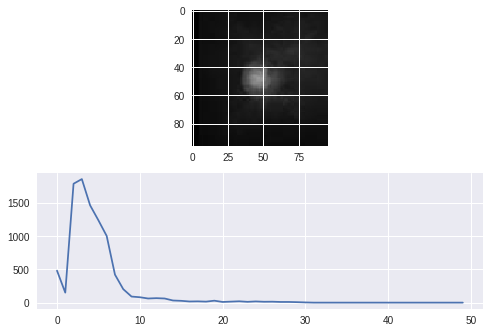

(50, 1)


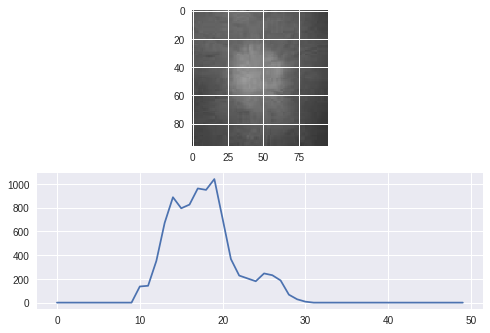

(50, 1)


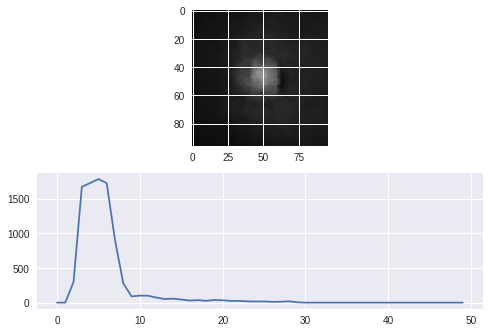

(50, 1)


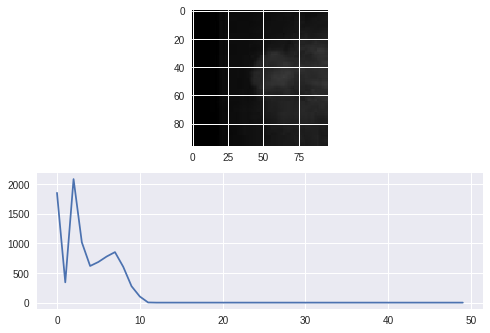

(50, 1)


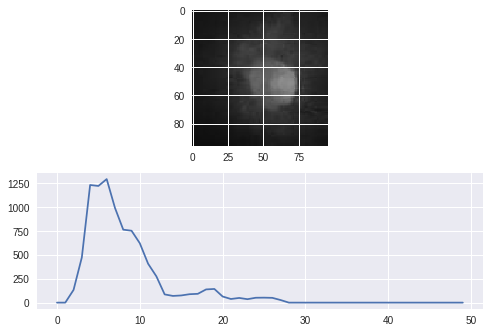

(50, 1)


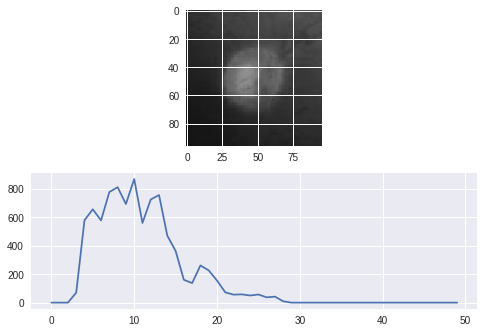

(50, 1)


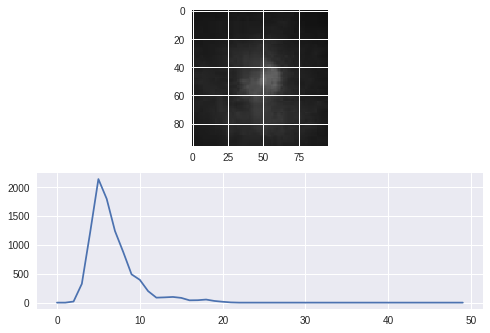

(50, 1)


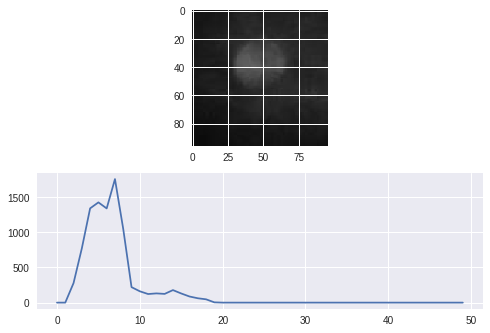

(50, 1)


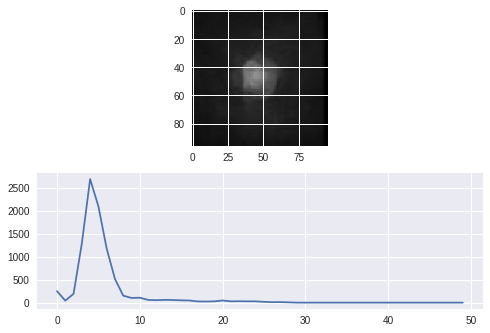

(50, 1)


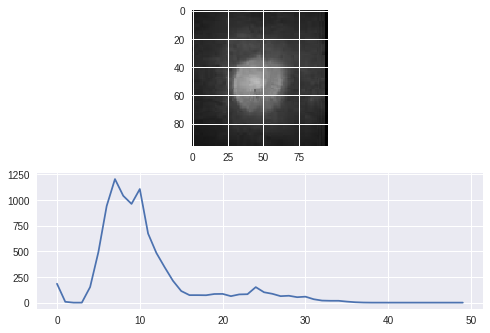

(50, 1)


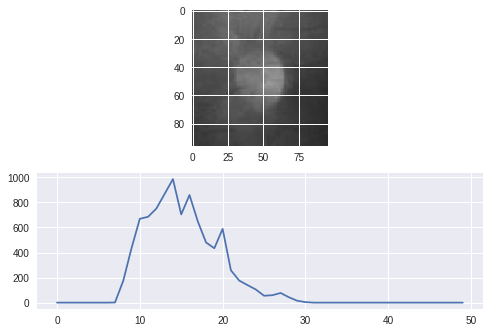

(50, 1)


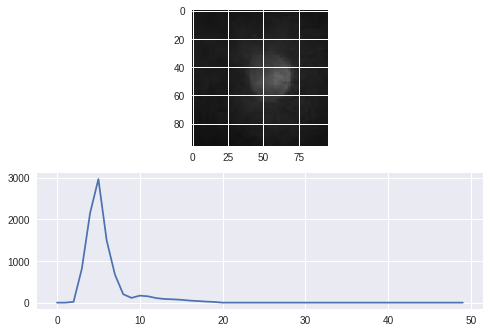

(50, 1)


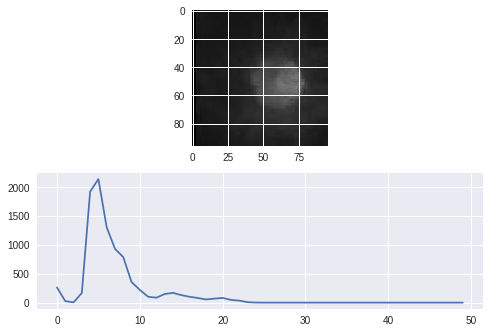

(50, 1)


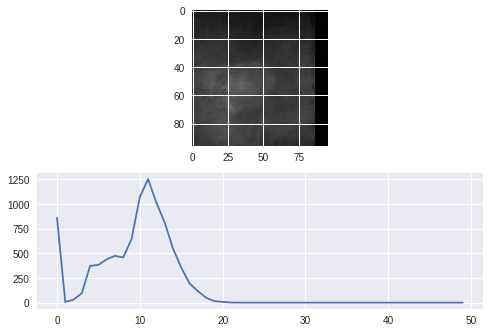

(50, 1)


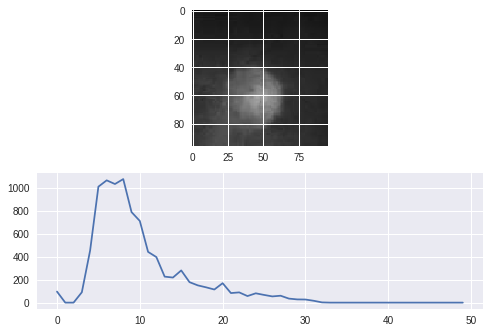

(50, 1)


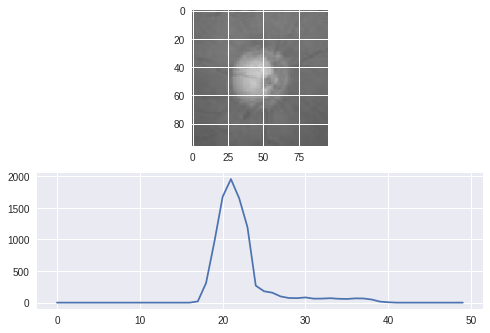

(50, 1)


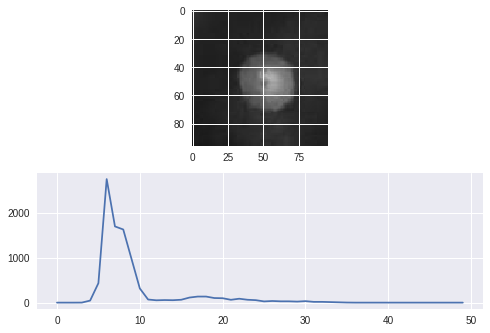

(50, 1)


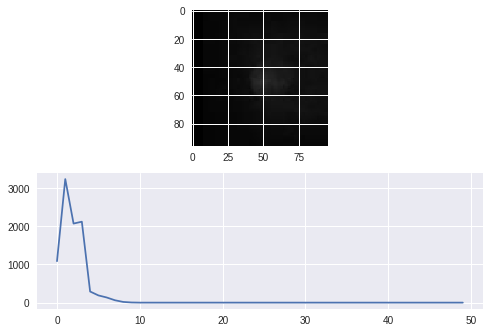

(50, 1)


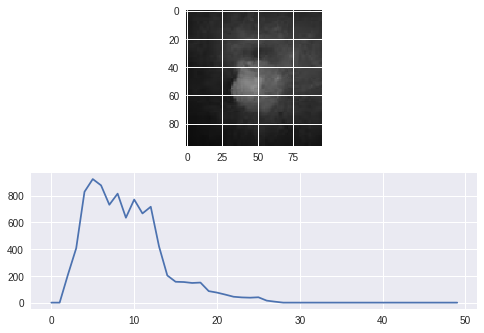

(50, 1)


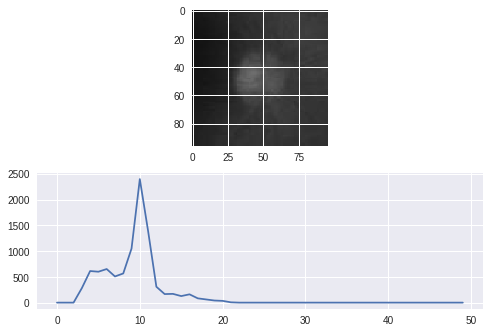

(50, 1)


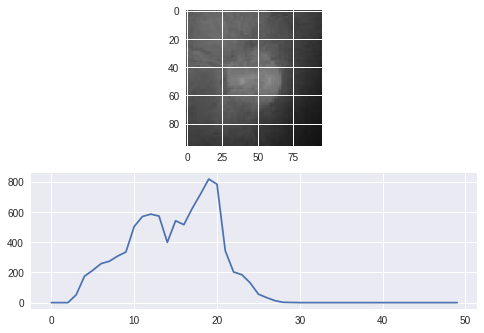

(50, 1)


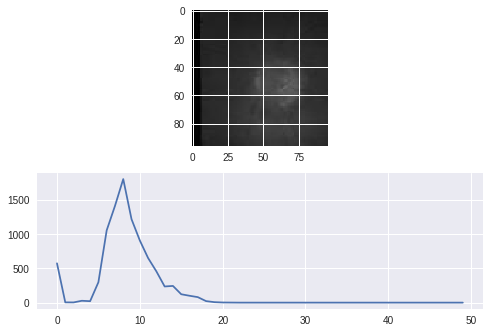

(50, 1)


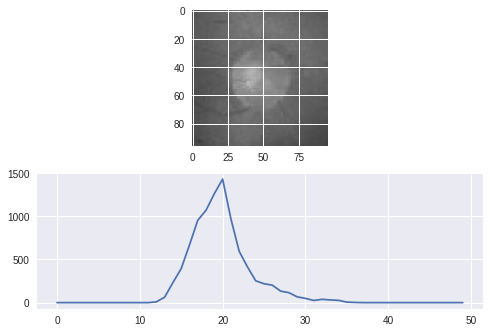

(50, 1)


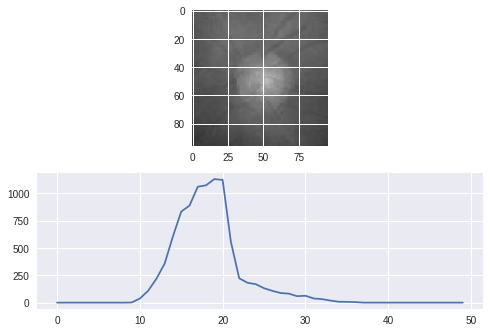

(50, 1)


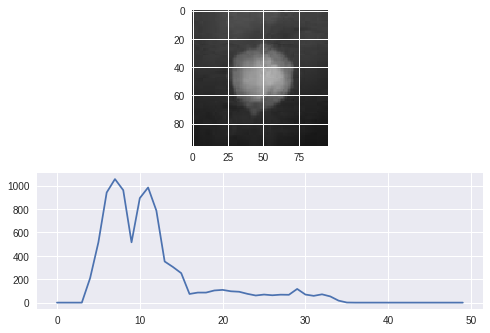

(50, 1)


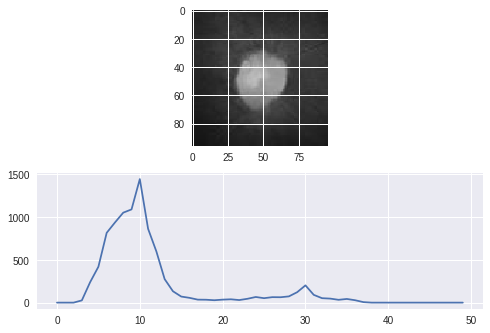

(50, 1)


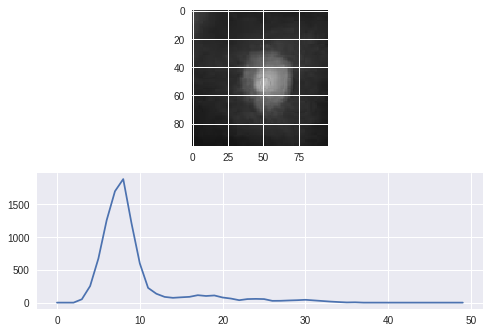

In [35]:
# find frequency of pixels in range 0-255
histograms = {}
i = 1
for n in os.listdir("PUBLIC_FUNDUS/normal"):
  n = cv2.imread("PUBLIC_FUNDUS/normal/"+n)
  f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  axarr[0].imshow(n)
  print(histr.shape)
  # show the plotting graph of an image
  axarr[1].plot(histr)
  plt.show()


# GMM on Histogram

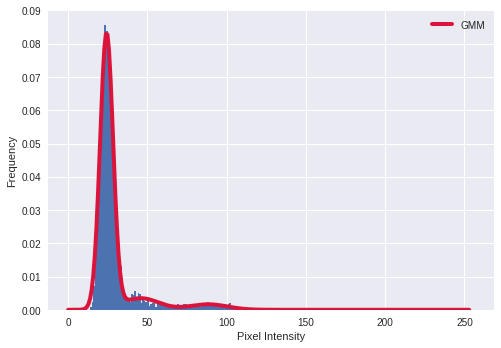

In [36]:
from sklearn.mixture import GaussianMixture

# Read image
img = cv2.imread("PUBLIC_FUNDUS/glaucoma/"+os.listdir("PUBLIC_FUNDUS/glaucoma")[2])

hist = cv2.calcHist([img],[0],None,[255],[0,256])
hist[0] = 0     # Removes background pixels

data = img.ravel()
data = data[data != 0]
data = data[data != 1]  #Removes background pixels (intensities 0 and 1)

# Fit GMM
gmm = GaussianMixture(n_components = 3)
gmm = gmm.fit(X=np.expand_dims(data,1))

# Evaluate GMM
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# Plot histograms and gaussian curves
fig, ax = plt.subplots()
ax.hist(img.ravel(),255,[2,256], normed=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()

plt.show()

In [0]:
def return_features(data):
  data = data[data != 0]
  data = data[data != 1]  #Removes background pixels (intensities 0 and 1)

  # Fit GMM
  gmm = GaussianMixture(n_components = 3)
  gmm = gmm.fit(X=np.expand_dims(data,1))

  # Evaluate GMM
  gmm_x = np.linspace(0,253,256)
  gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
  #print(gmm.get_params)
  f = []
  f.extend(list(gmm.means_))
  f.extend(list(gmm.weights_))
  f.extend(list(gmm.covariances_))
  f.append(np.mean(data))
  f.append(np.var(data))
  f.append(np.percentile(data, 10))
  f.append(np.percentile(data, 90))
  f.append(max(data))
  return f

In [38]:
# find frequency of pixels in range 0-255
histograms_glaucoma = {}
i = 1
for n in os.listdir("PUBLIC_FUNDUS/glaucoma"):
  n = cv2.imread("PUBLIC_FUNDUS/glaucoma/"+n)
  #f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  #axarr[0].imshow(n)
  histograms_glaucoma[i] = return_features(histr)
  #show the plotting graph of an image
  #axarr[1].plot(histr[0])
  #plt.show()
  i+=1
histograms_normal = {}
i = 1
for n in os.listdir("PUBLIC_FUNDUS/normal"):
  n = cv2.imread("PUBLIC_FUNDUS/normal/"+n)
  #f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  #axarr[0].imshow(n)
  histograms_normal[i] = return_features(histr)
  # show the plotting graph of an image
  #axarr[1].plot(histr)
  #plt.show()
  i+=1
print(len(list(histograms_glaucoma.keys())))

144


# SVM for Histograms

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [89]:
from sklearn import svm
from sklearn.model_selection import train_test_split



X_g = [x for x in histograms_glaucoma.values()]
y_g = len(X_g)*[1]
X_n = [x for x in histograms_normal.values()]
y_n = len(X_n)*[0]
X = np.array(X_g + X_n)
y = np.array(y_g + y_n)
scale = StandardScaler()
scale.fit(X)
X = scale.transform(X)
#X, y = unison_shuffled_copies(X,y)
#X = pd.DataFrame(X)
#y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=76)
clf = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.01, verbose=False)




/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.01, verbose=False)

In [99]:
#clf.fit(X_train, y_train)  
#print(clf.score(X_test,y_test))

#from sklearn import metrics


skf = StratifiedKFold(n_splits=5,shuffle=True)
scores = cross_val_score(
     clf, X, y, cv=skf,scoring="f1")
scores
#sum(scores)/len(scores)

#scores = []
#for train_index, test_index in skf.split(X, y):
#      X_train, X_test = X[train_index], X[test_index]
#      y_train, y_test = y[train_index], y[test_index]
#      clf.fit(X_train, y_train)
#      scores.append(clf.score(X_test,y_test))
#print(scores)

array([0.69444444, 0.6       , 0.68571429, 0.66666667, 0.71428571])

# Gabor Filters

In [0]:
def build_filters():
  filters = []
  ksize = 31
  for theta in np.arange(0, np.pi, np.pi / 16):
    kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, .5, 0, ktype=cv2.CV_32F)
    kern /= 1.5*kern.sum()
    filters.append(kern)
  return filters
 
def process(img, filters):
  accum = np.zeros_like(img)
  for kern in filters:
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
    np.maximum(accum, fimg, accum)
  return accum


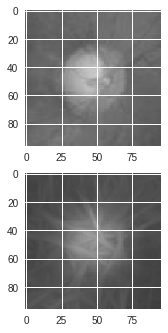

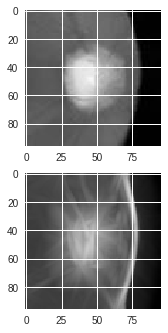

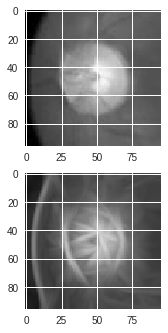

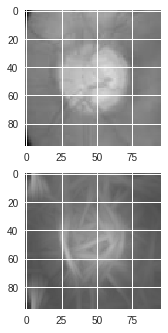

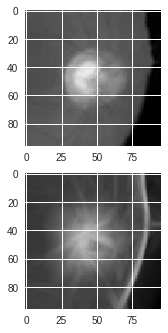

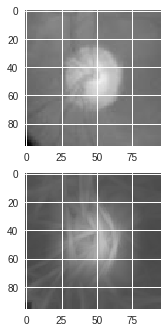

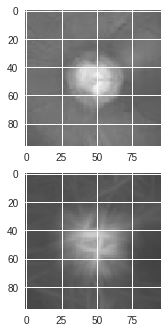

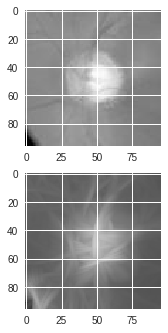

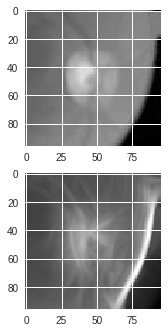

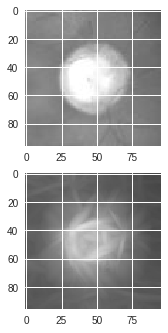

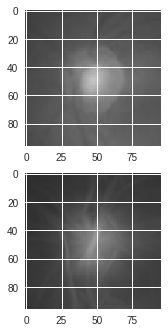

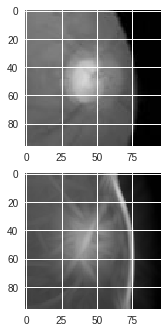

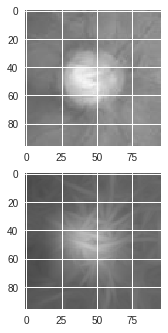

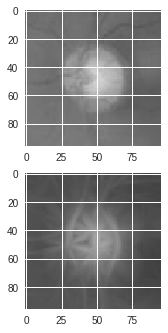

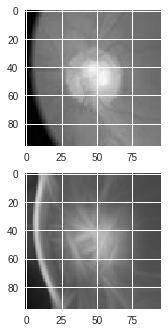

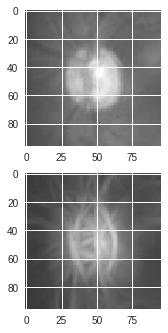

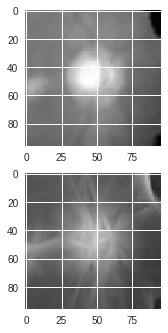

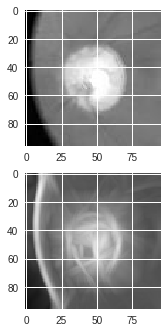

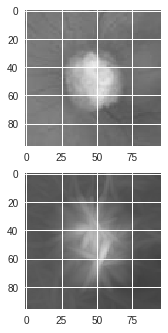

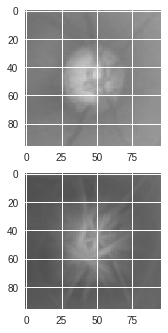

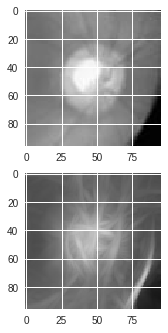

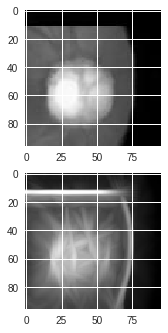

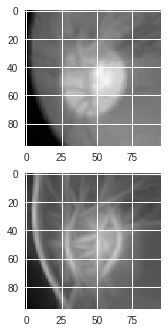

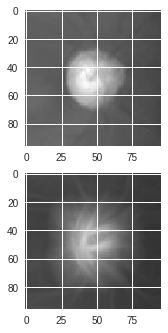

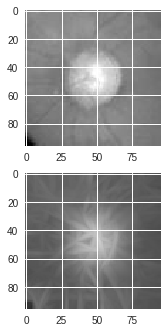

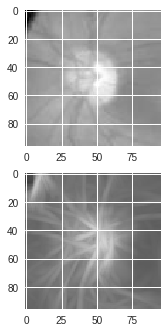

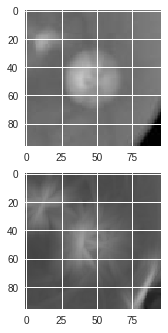

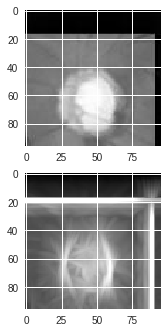

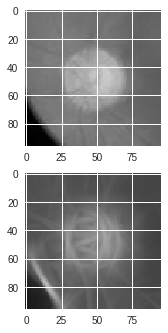

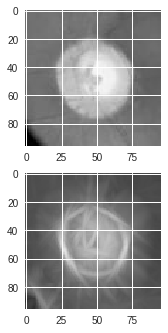

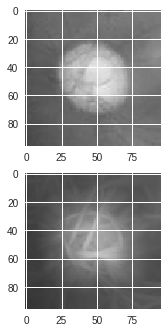

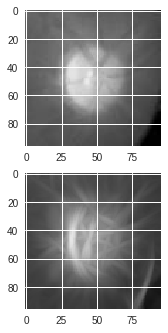

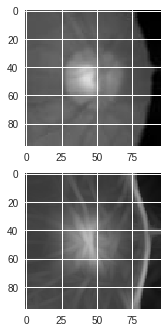

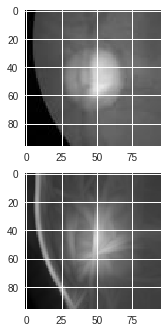

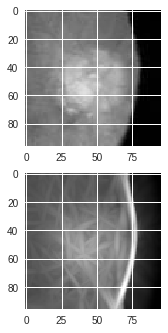

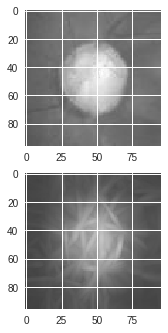

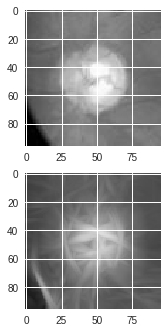

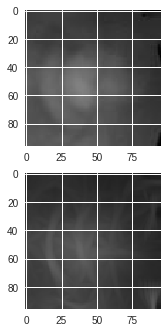

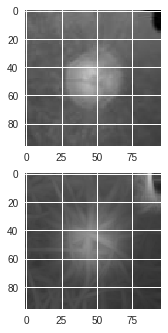

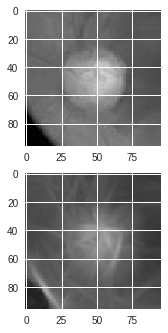

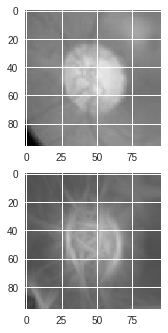

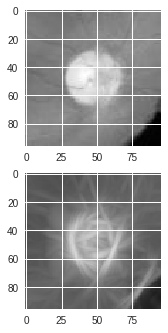

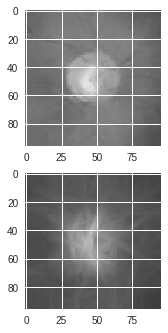

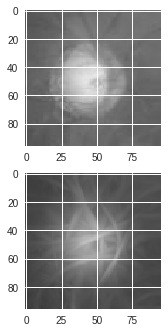

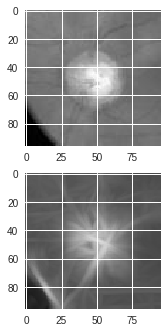

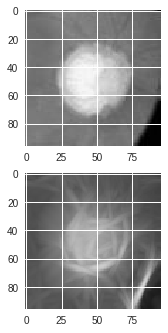

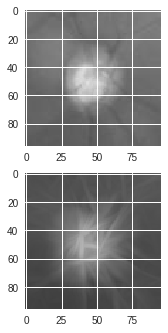

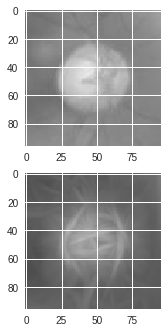

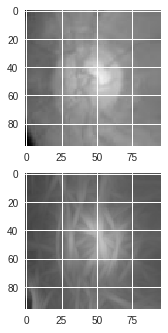

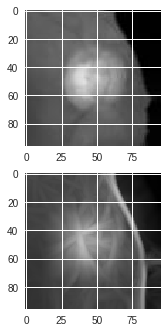

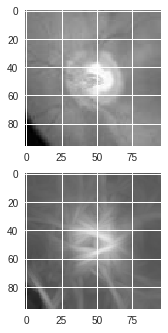

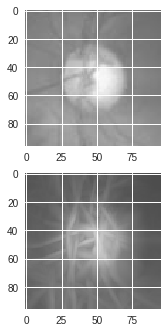

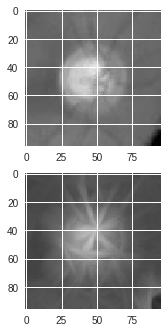

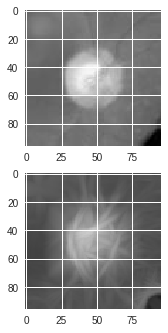

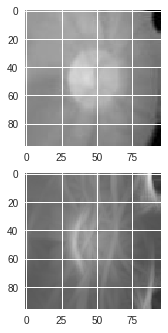

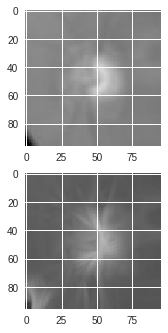

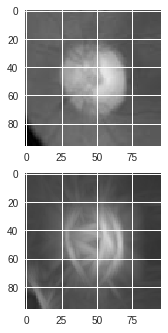

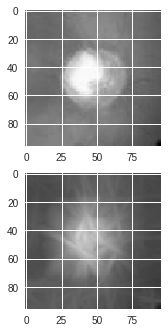

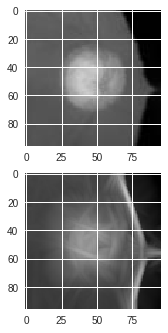

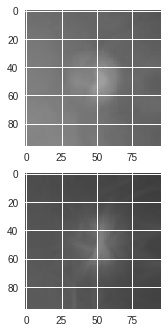

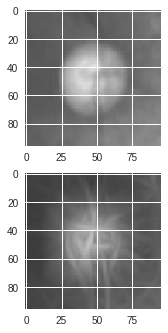

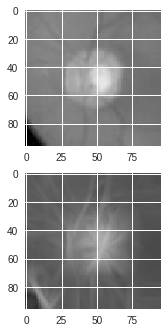

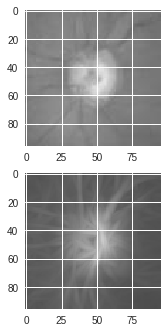

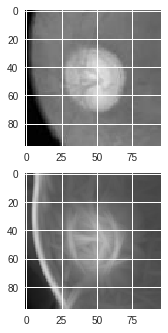

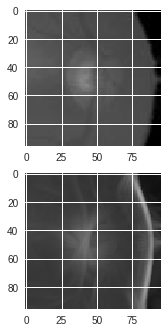

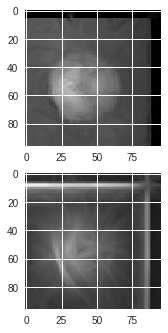

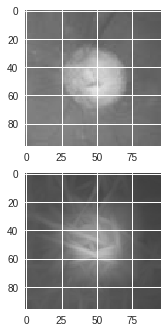

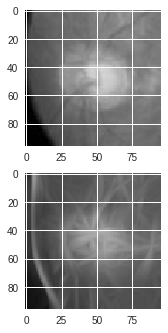

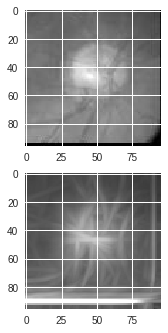

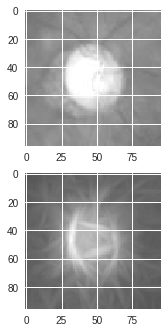

In [0]:
for next_glaucoma in os.listdir("FundusImagesv4/glaucoma"):
  t = cv2.imread("FundusImagesv4/glaucoma/"+next_glaucoma)
  f, axarr = plt.subplots(2)
  axarr[0].imshow(t)
  filters = build_filters()
  res1 = process(t, filters)
  axarr[1].imshow(res1)
  plt.show()

# PCA and LDA for Dimensionality Reduction

In [0]:
# try using standard scaler
from sklearn.decomposition import PCA
X_g2 = []
X_n2 = []
for next_image in os.listdir("PUBLIC_FUNDUS/glaucoma"):
  X_g2.append(cv2.imread("PUBLIC_FUNDUS/glaucoma/"+next_image,0).ravel())
for next_image in os.listdir("PUBLIC_FUNDUS/normal"):
  X_n2.append(cv2.imread("PUBLIC_FUNDUS/normal/"+next_image,0).ravel())
y_g2 = len(X_g2)*[1]
y_n2 = len(X_n2)*[0]
X2 = X_g2+X_n2
y2 = y_g2 + y_n2
pca = PCA(n_components = 30,svd_solver='randomized')
pca.fit(X2)

X_prime = []
scaler = StandardScaler()
#for next_row in X:
 # mean, X_eigenVectors = cv2.PCACompute(next_row, mean=None, retainedVariance=.95)
 # X_prime.append(X_eigenVectors)
X2 = pca.transform(X2)
#proj = pca.inverse_transform(X)
scaler.fit(X2)
X2 = scaler.transform(X2)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2,random_state=97,shuffle=True)
#print(np.array(train_img).shape)



In [0]:
clf_piv = svm.SVC(C=1)


In [272]:

correct = 0
incorrect = 0
skf = StratifiedShuffleSplit(n_splits=5)
scores = []
for train_index, test_index in skf.split(X2, y2):
  X_train2, X_test2 = X2[train_index], X2[test_index]
  y_train2, y_test2 = np.array(y2)[train_index], np.array(y2)[test_index]
  clf_piv.fit(X_train2,y_train2)
  for k,v in zip(X_test2,y_test2):
    k = np.array(k).reshape(1, -1)
    p = clf_piv.predict(k)
    if int(p) == int(v):
      correct+=1
    else:
      incorrect+=1
  scores.append(correct / (correct + incorrect))
print(scores )

[0.8076923076923077, 0.7307692307692307, 0.717948717948718, 0.6538461538461539, 0.6923076923076923]


max: 85 accuracy, CV average: ~70%, max CV: 80%

# Decision Trees on PIV

In [0]:
clf_piv_dt = tree.DecisionTreeClassifier()
clf_piv_dt = clf_piv_dt.fit(X2, y2)

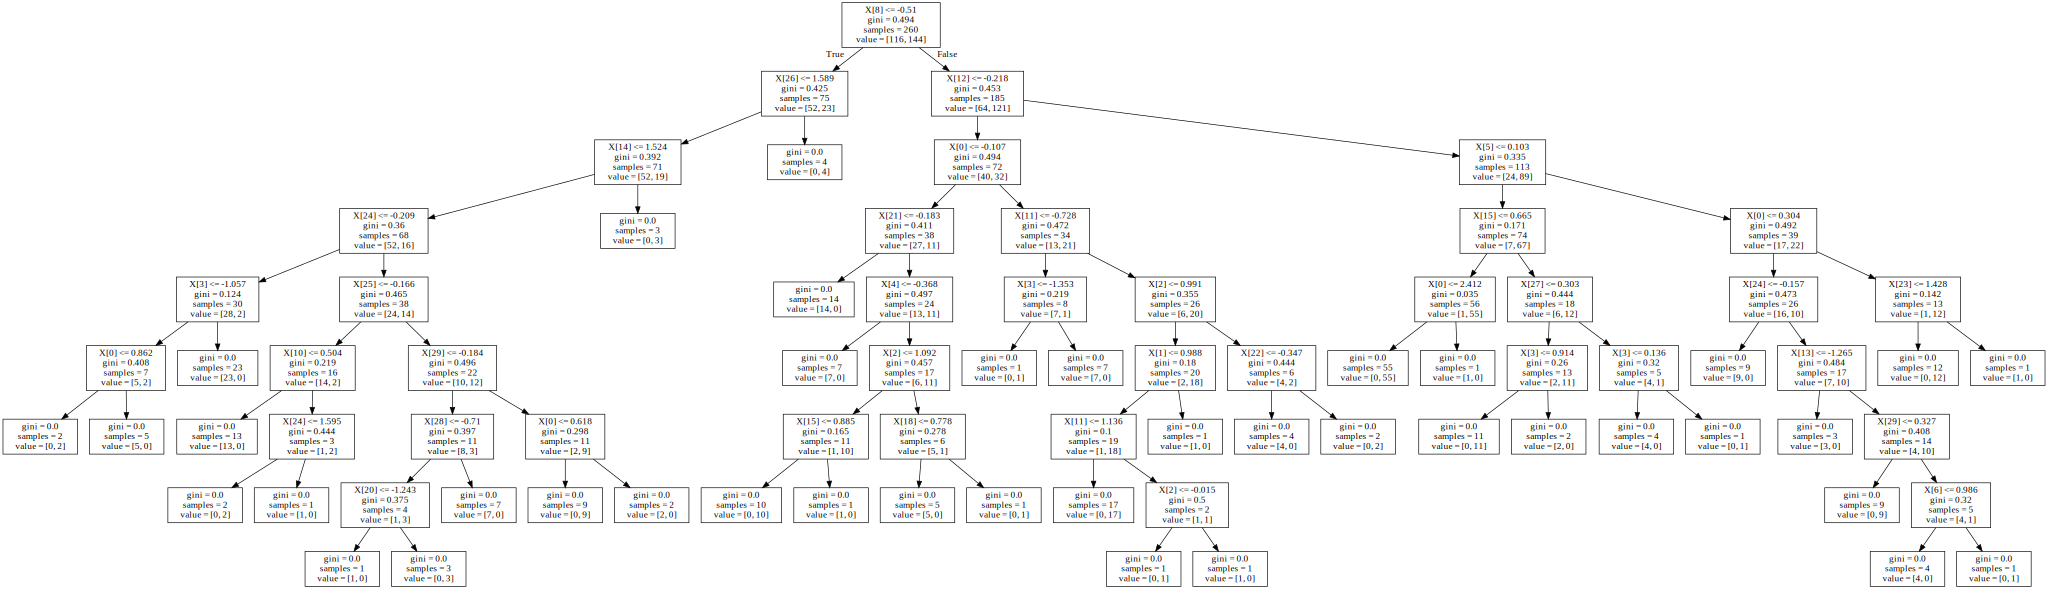

In [274]:

dot_data = tree.export_graphviz(clf_piv_dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("decision tree on pixel values")
graph

# Notes / Further Work

**Notes and to do:**

1. Using precedent from this paper - file:///C:/Users/Avyuk%20Dixit/Downloads/Classifying_Glaucoma_with_Image-Based_Features_fro.pdf - make sure to cite it

2. Three features - 1) pixel intensity values 2) histogram analysis of values, and 3) texture from gabor filter values

3. Do PCA on all features to reduce dimensionality - train and test SVM on each feature individually, and then merge all features and test SVM on it

4. Get all fundus images together on computer so we have a final train and test set, probably > 10000 images in total (what minimum split does there have to be between glaucoma vs non-glaucoma???)

5. Reconstruct from PCA to make predicitions 